In [1]:
from pathlib import Path
import sys
import json
import datetime

PROJ_DIR = Path.cwd().parent.parent
sys.path.append(str(PROJ_DIR))

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation
import matplotlib.font_manager as fm
from IPython.display import HTML

import numpy as np
import pandas as pd

from src.defaults import ROOT_DIR
from src.checkpoint import CheckpointableData, Checkpointer
from src.config import BaseConfig, Require
from src.shared import get_env
from src.smbpo import SMBPO
from src.tester import Tester

fm.fontManager.addfont('../resources/arial.ttf')

ROOT_DIR = Path(ROOT_DIR)
assert ROOT_DIR.is_dir(), ROOT_DIR
LOGS_DIR = ROOT_DIR / 'logs' / 'tracking'

params = {
    'font.family': 'Arial',
    'font.serif': 'Arial',
    # 'font.style': 'italic',
    # 'font.weight': 'normal', #or 'blod'
    'font.size': 15,  # or large,small
    'animation.ffmpeg_path': r'/usr/bin/ffmpeg'
}
rcParams.update(params)

class Config(BaseConfig):
    env_name = Require(str)
    env_cfg = {}
    seed = 1
    epochs = 600
    alg_cfg = SMBPO.Config()
    alg = 'DRPO'

/home/yudongjie/anaconda3/envs/smbrl/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test log directory: /home/yudongjie/safe_proj/Safe_MBRL/logs/tracking/02-18-23_00.35.25_DRPO_22/test-2023-02-18-11-40-43
Set log dir to /home/yudongjie/safe_proj/Safe_MBRL/logs/tracking/02-18-23_00.35.25_DRPO_22/test-2023-02-18-11-40-43, log filename to log.txt
Creating new log file named log.txt
[11:40:43] Test log directory: /home/yudongjie/safe_proj/Safe_MBRL/logs/tracking/02-18-23_00.35.25_DRPO_22/test-2023-02-18-11-40-43


/home/yudongjie/safe_proj/safe-control-gym/safe_control_gym/utils/configuration.py:72: UserWarning: No agent/task config given.
  warnings.warn("No agent/task config given.")
/home/yudongjie/anaconda3/envs/smbrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[11:40:45] Data load succeeded
[11:40:45] Solver load epoch 460 succeeded
surr 0: d_lon: 8, d_lat: 3.5, u: 4.5


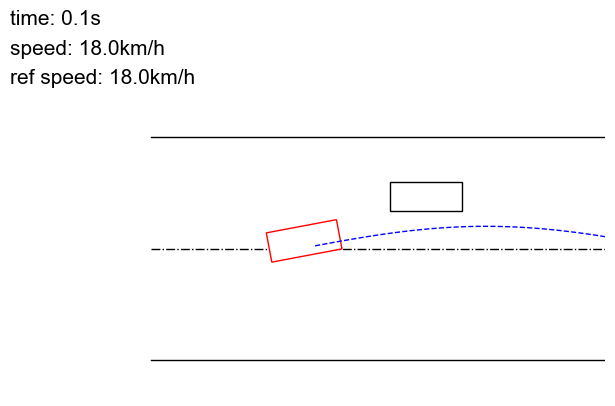

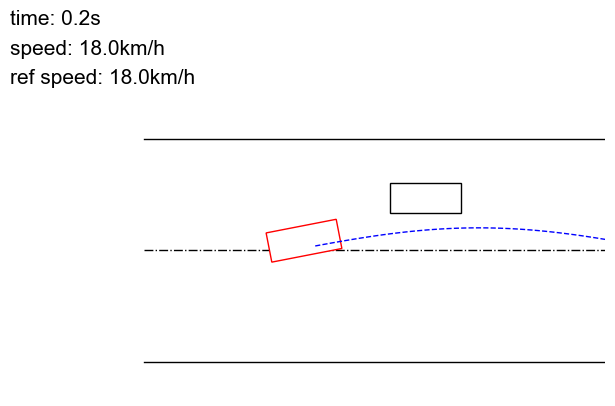

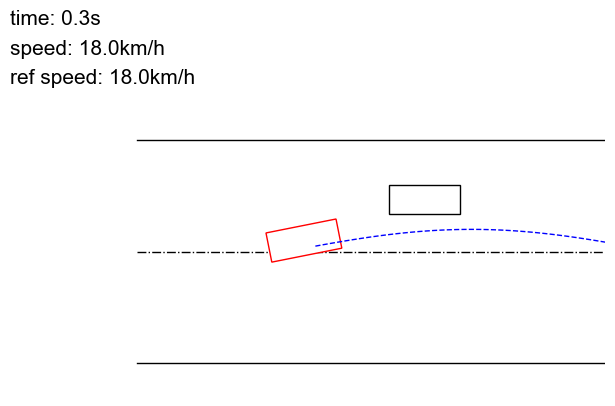

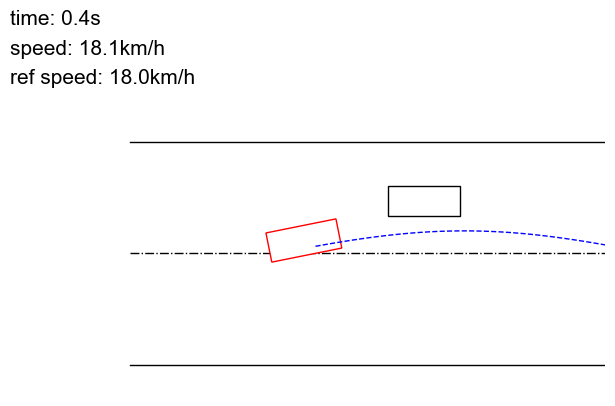

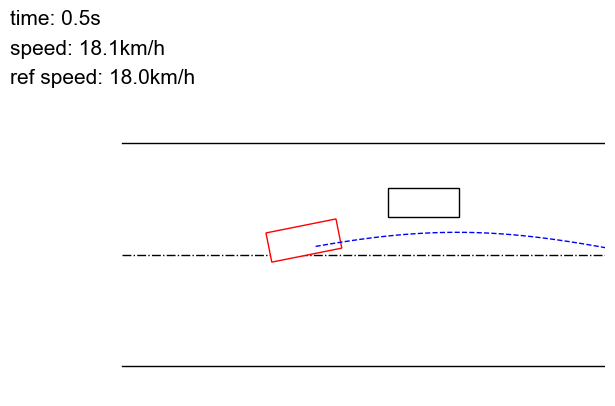

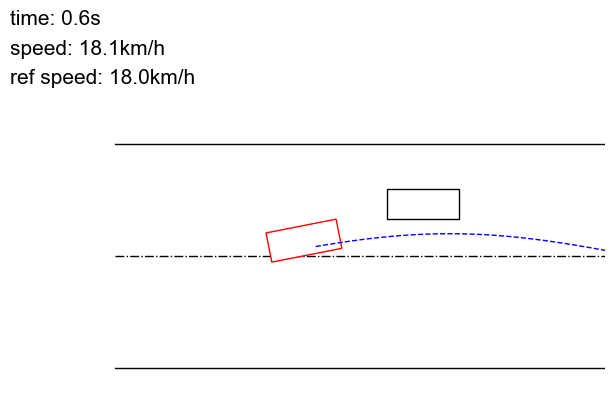

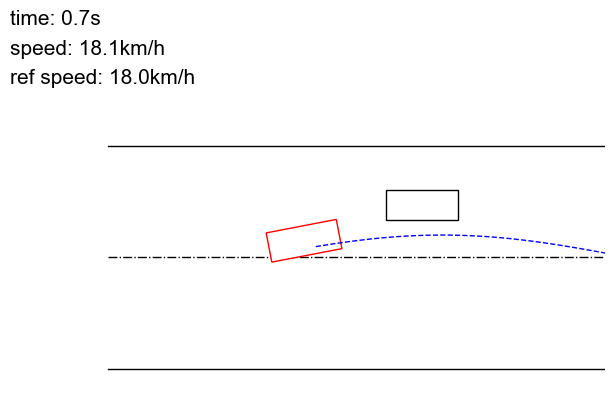

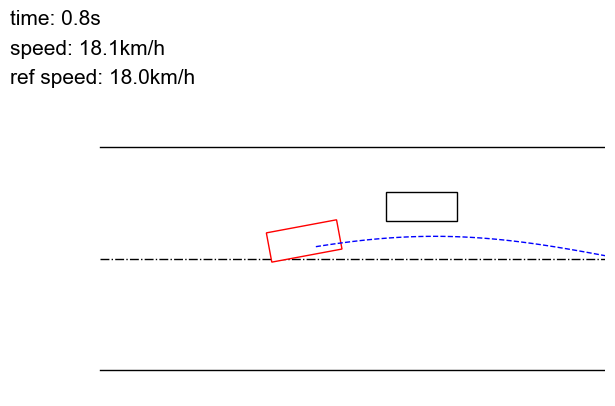

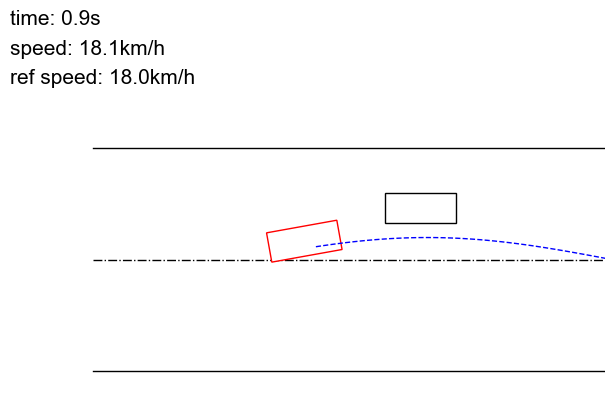

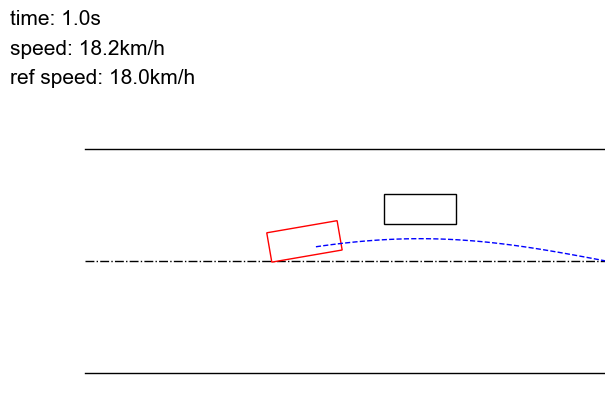

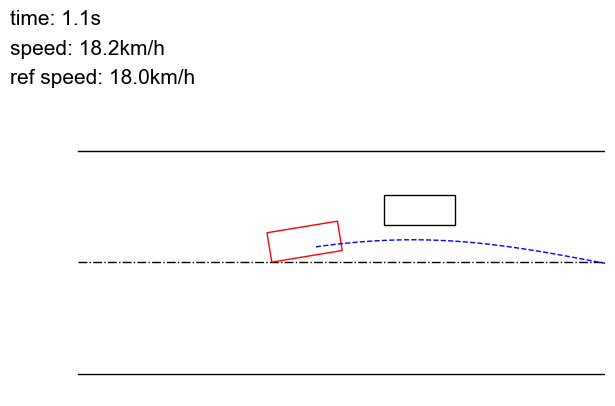

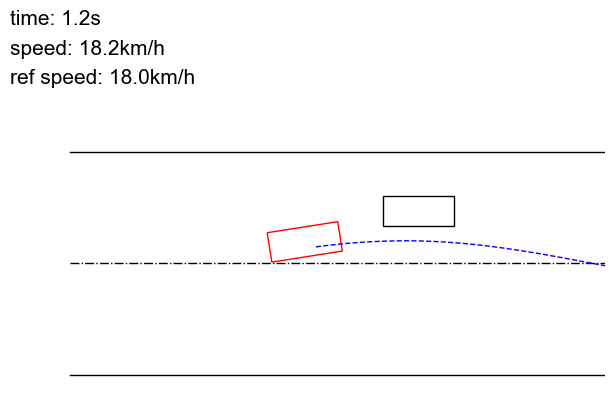

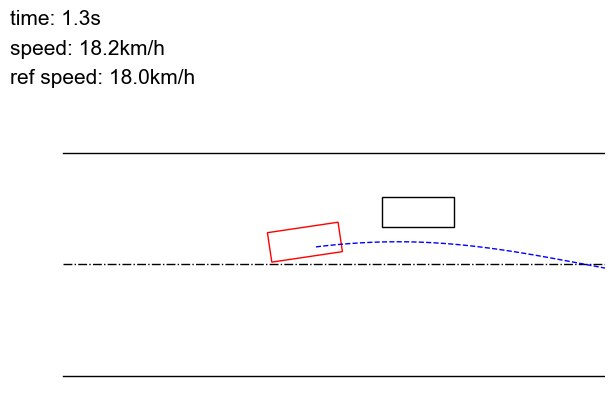

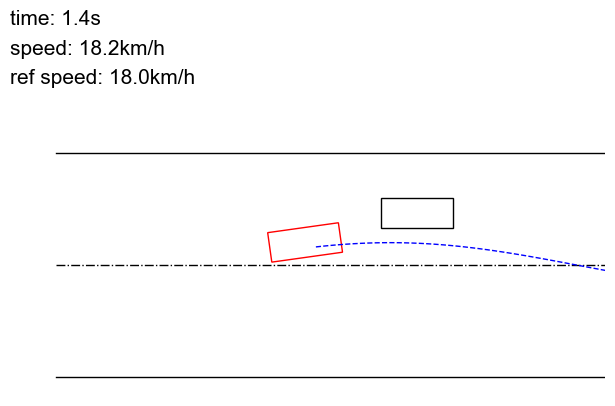

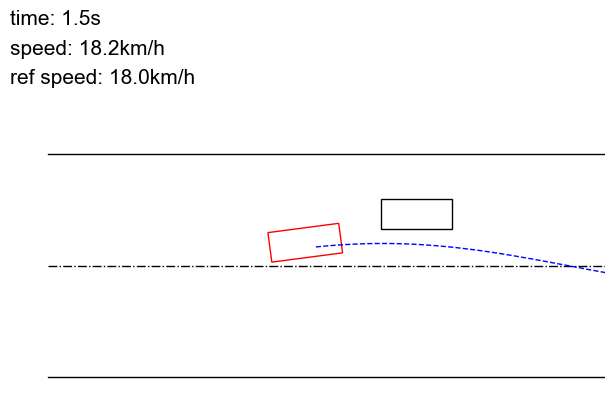

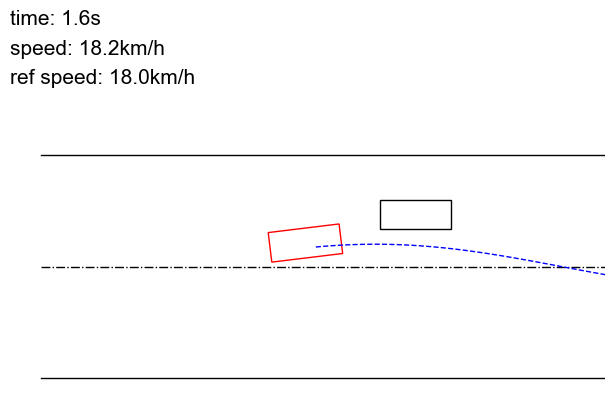

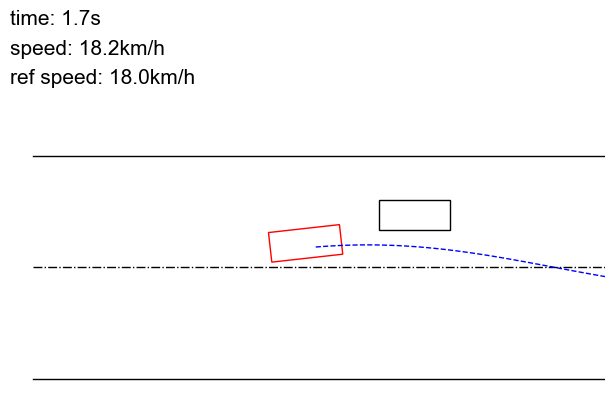

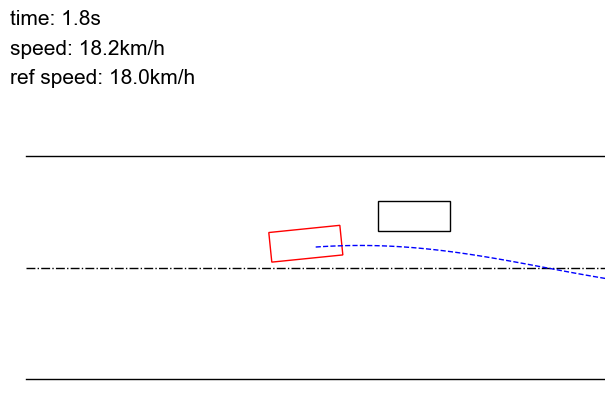

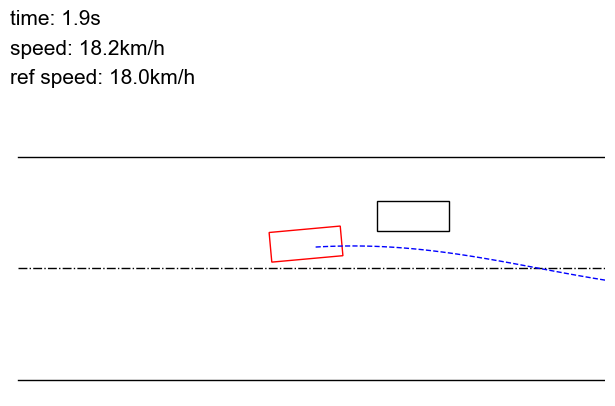

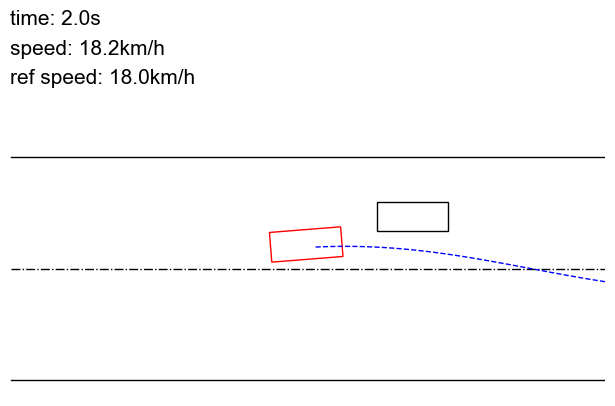

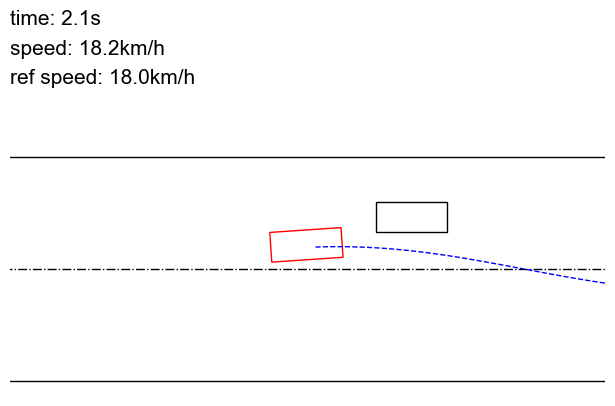

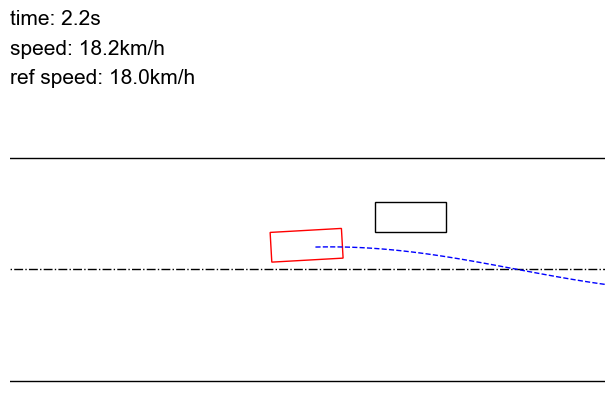

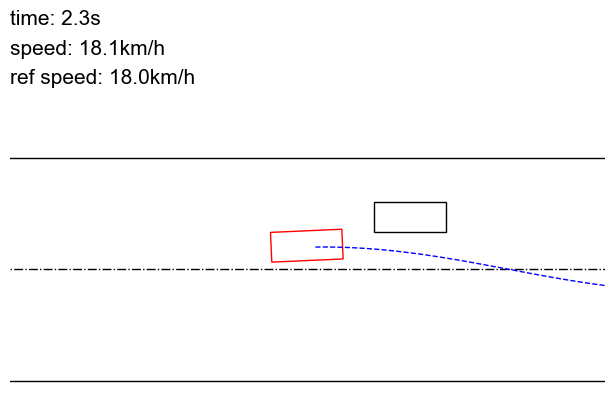

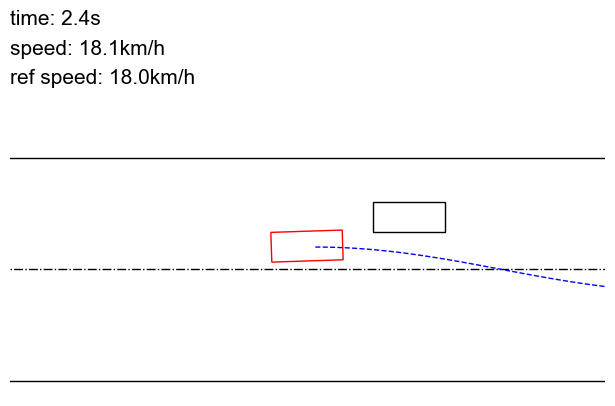

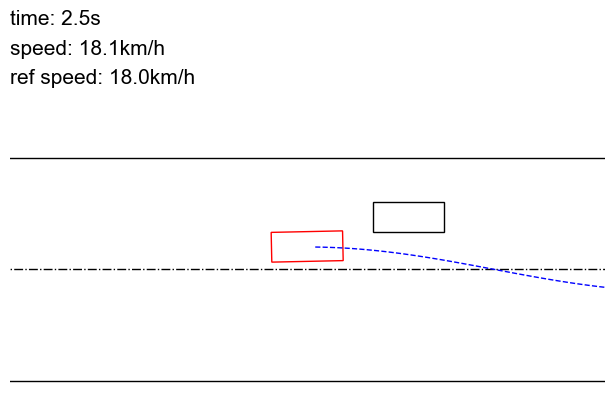

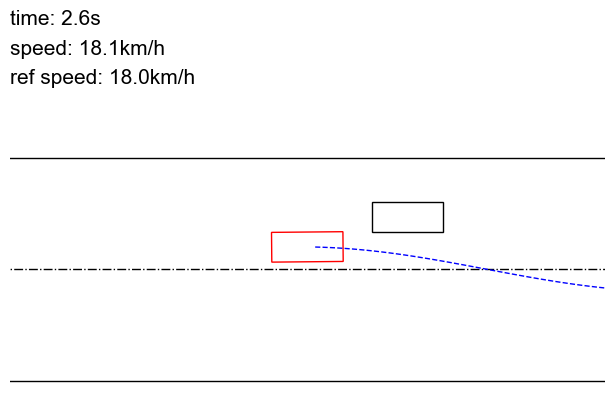

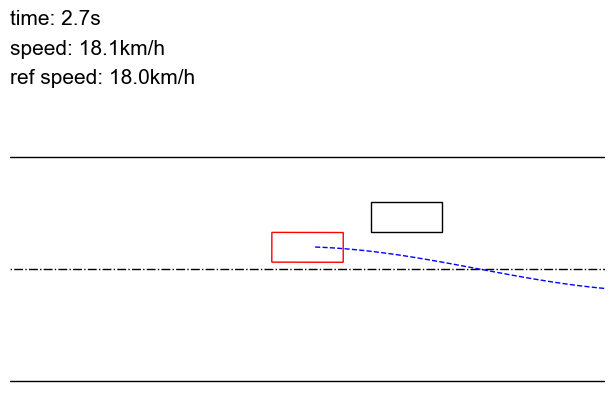

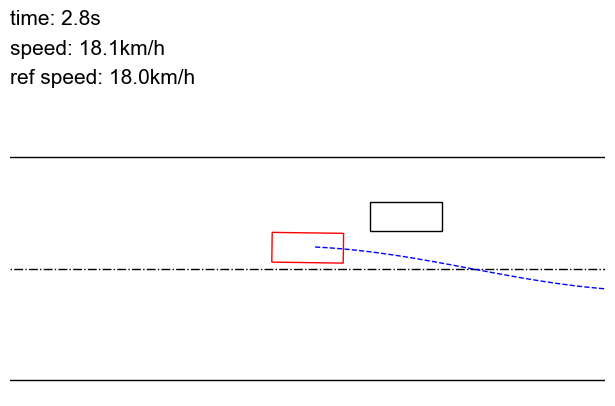

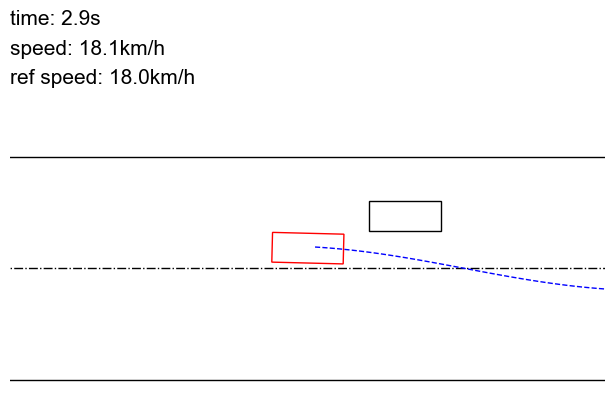

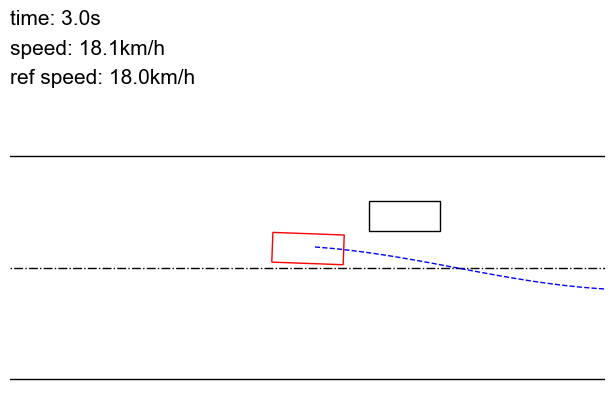

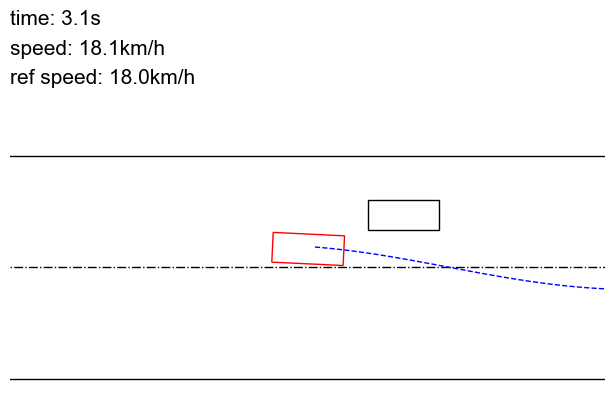

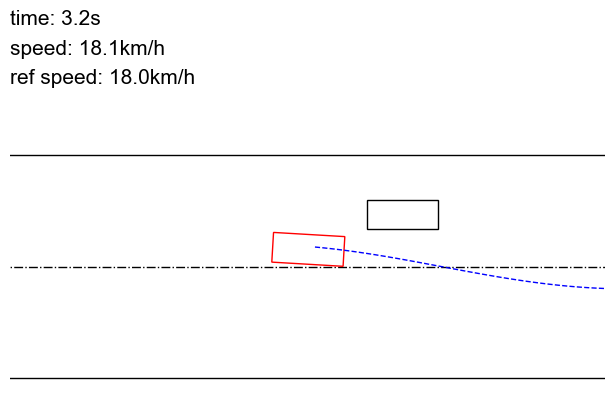

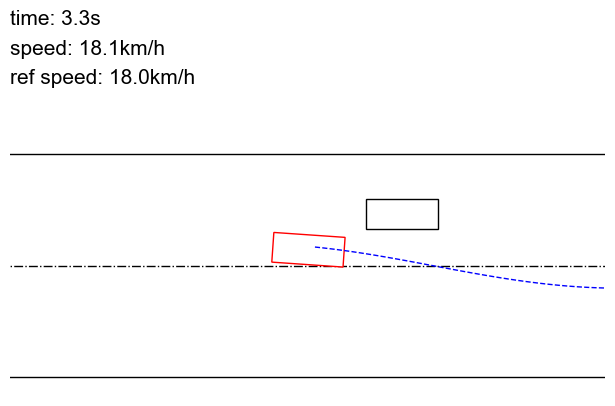

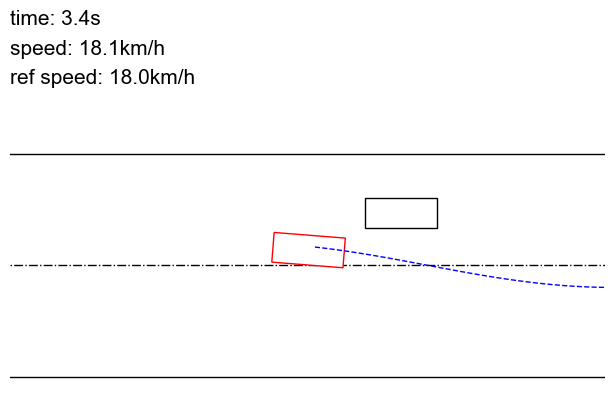

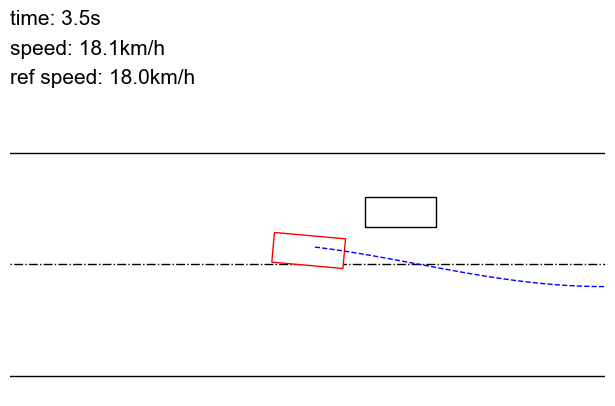

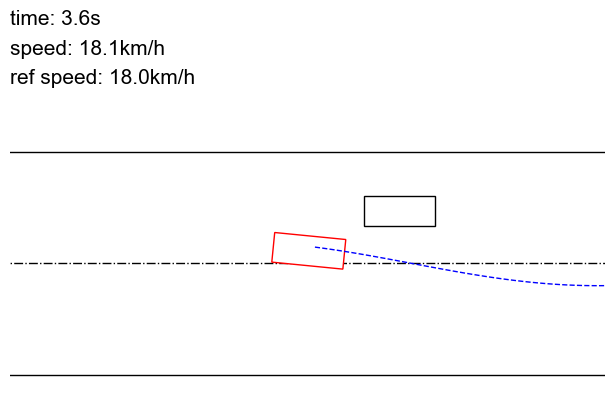

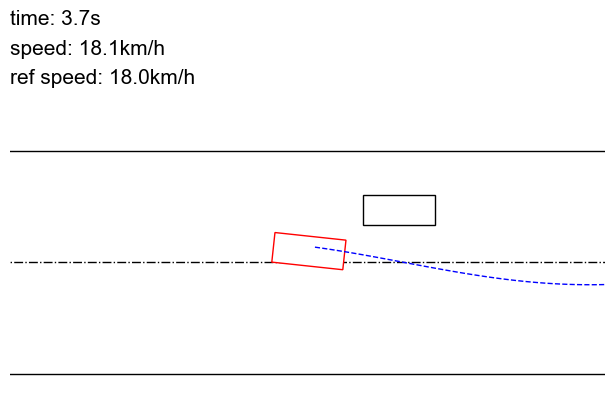

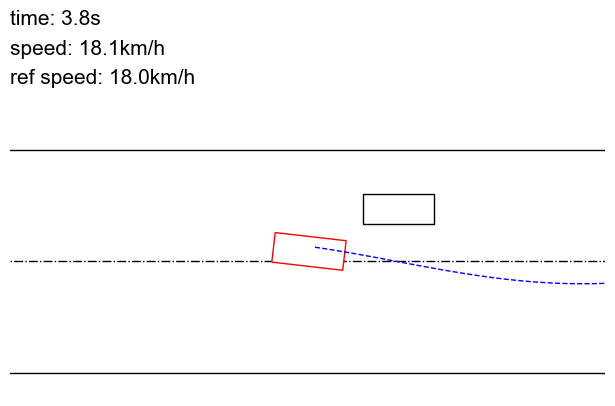

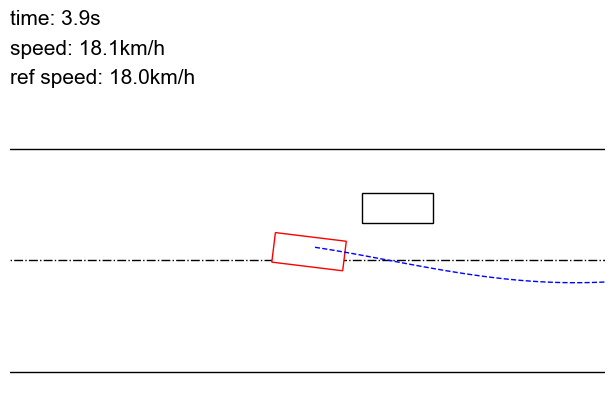

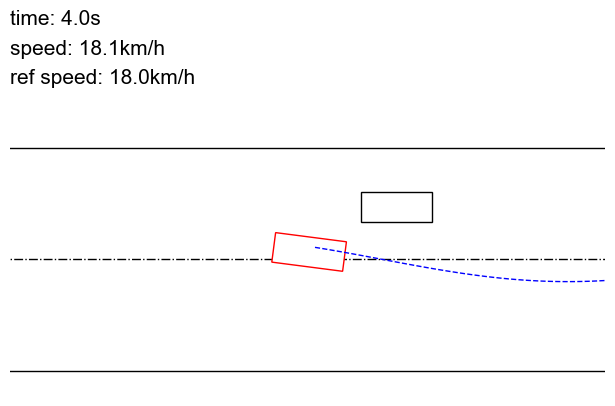

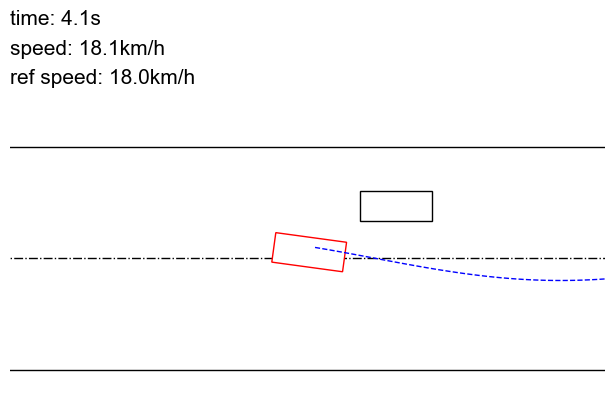

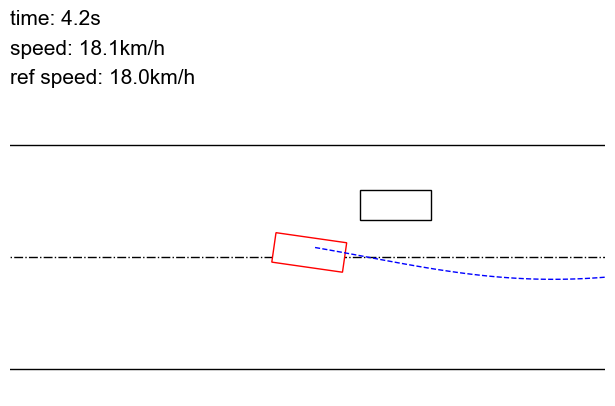

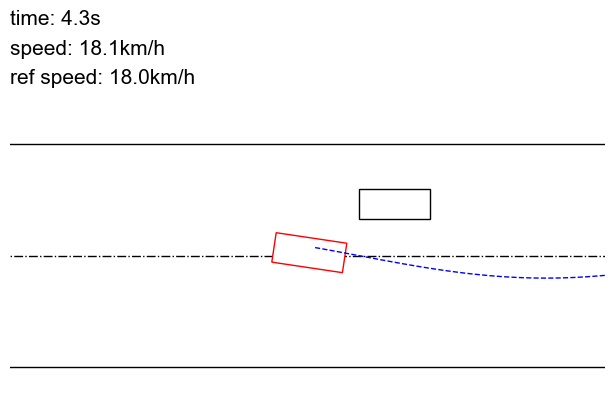

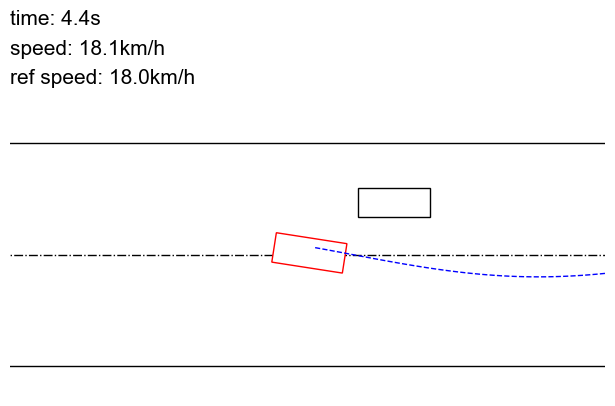

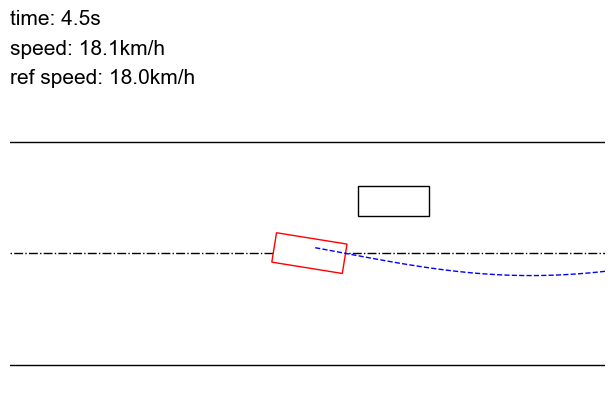

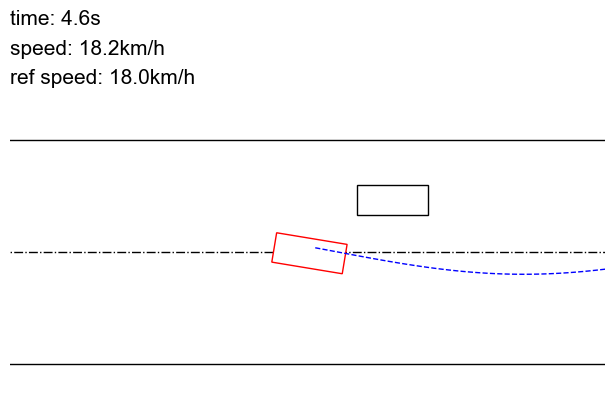

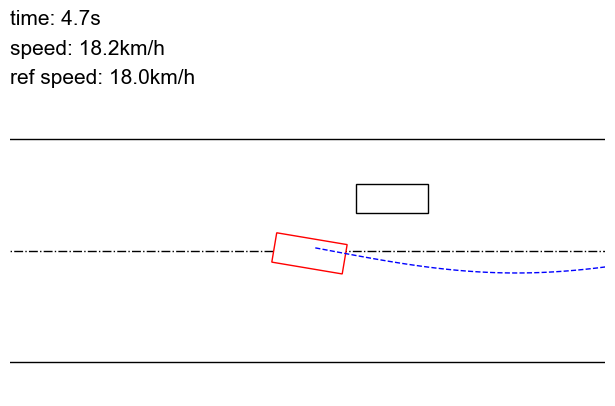

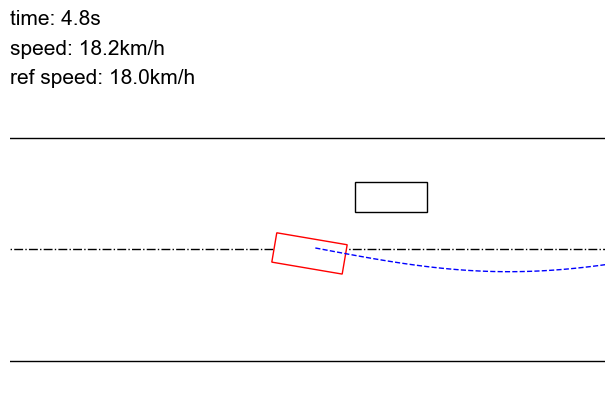

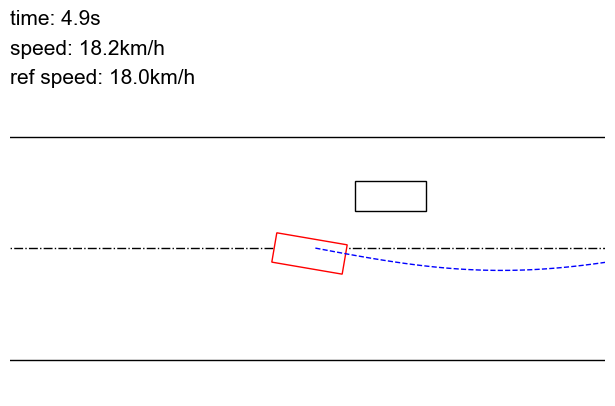

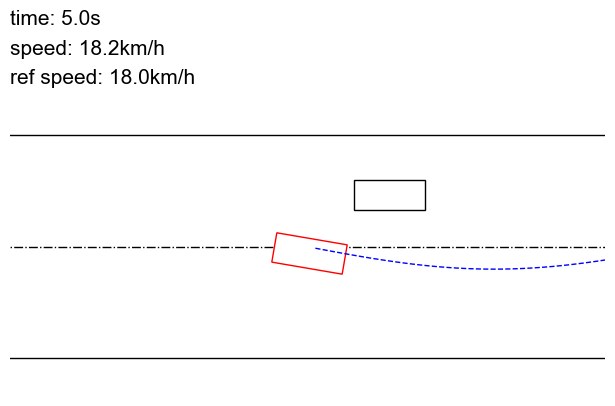

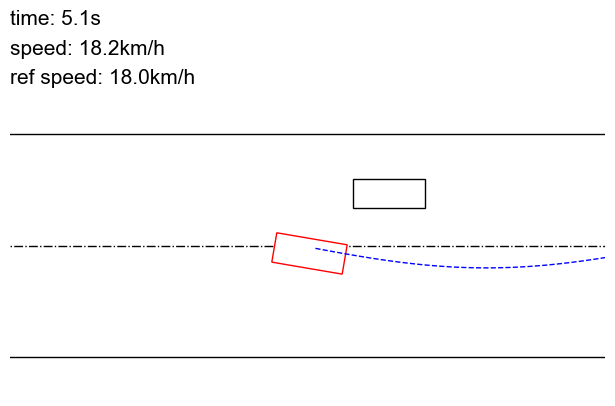

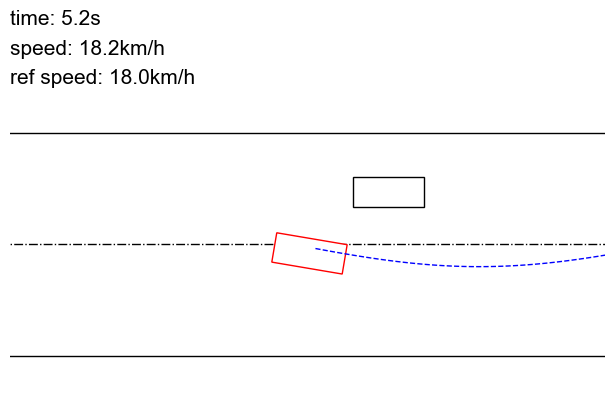

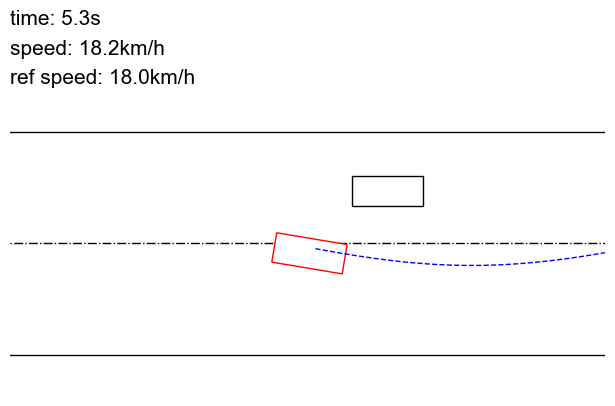

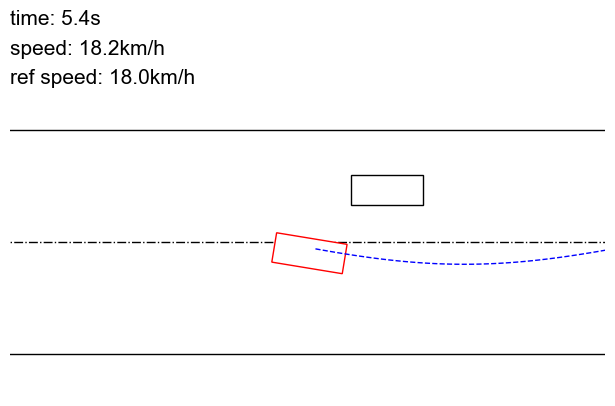

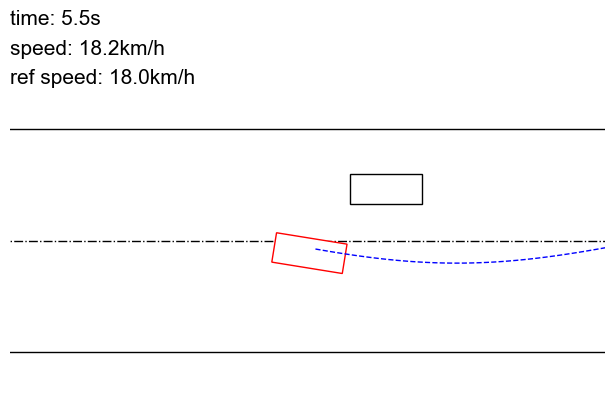

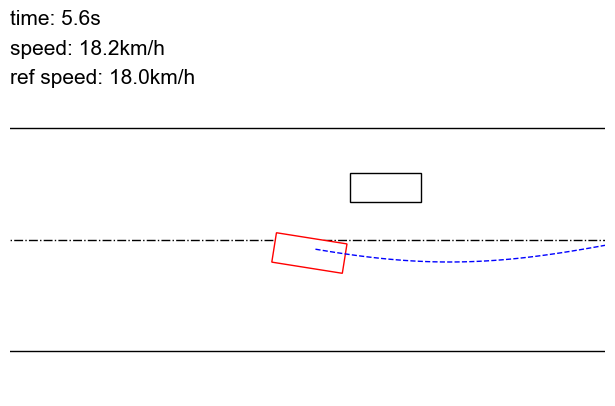

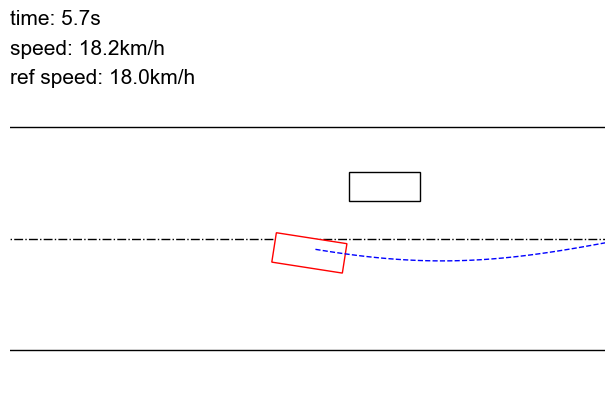

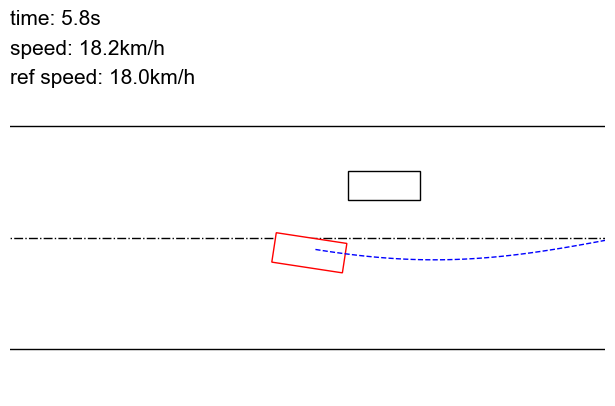

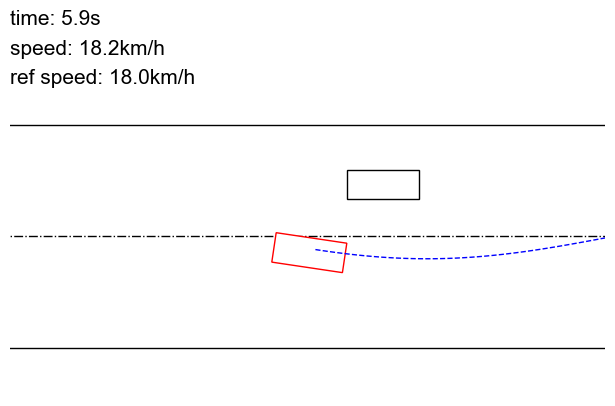

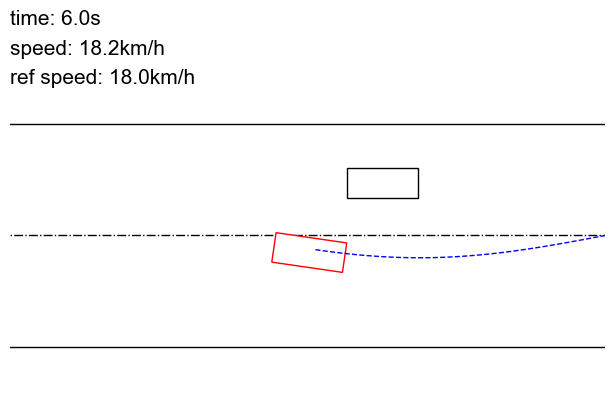

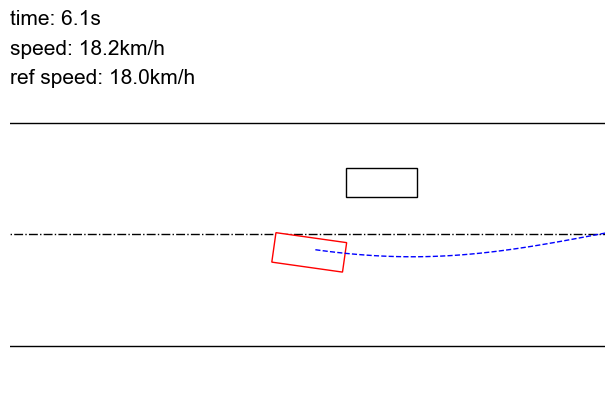

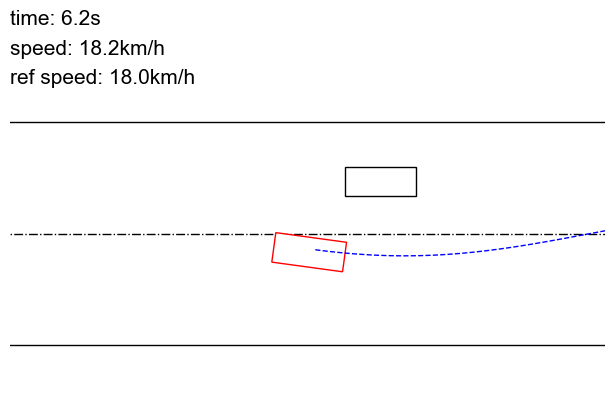

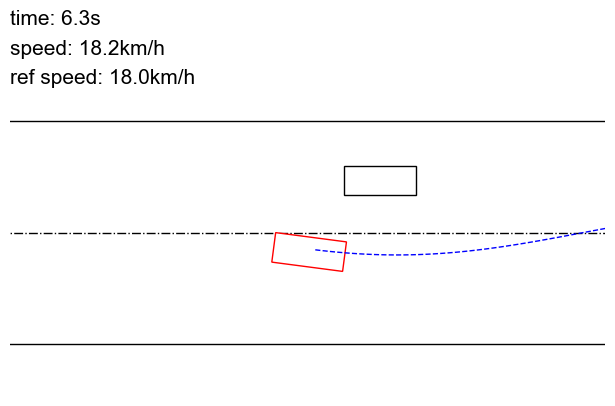

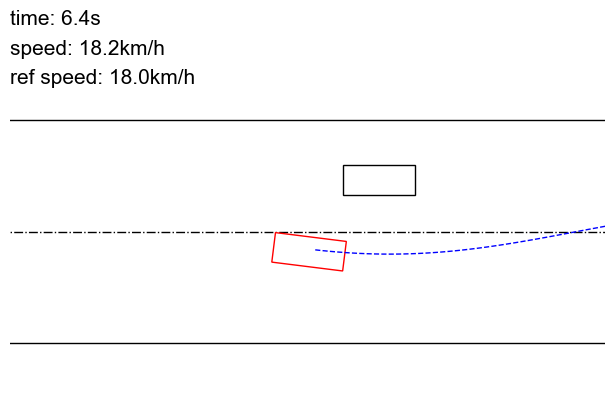

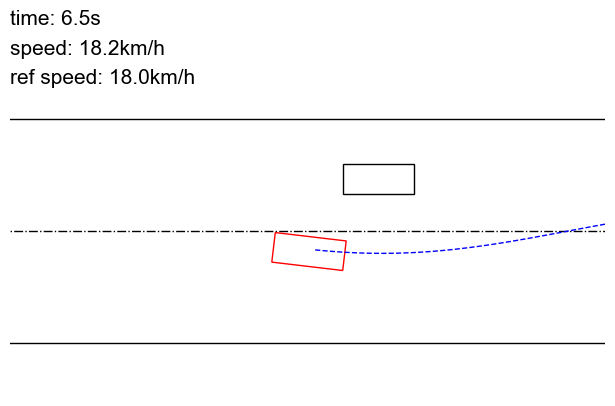

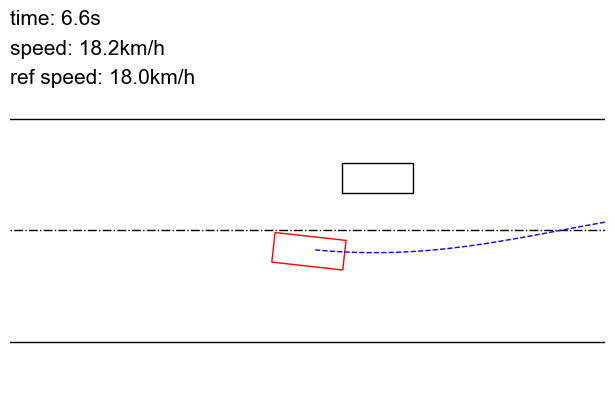

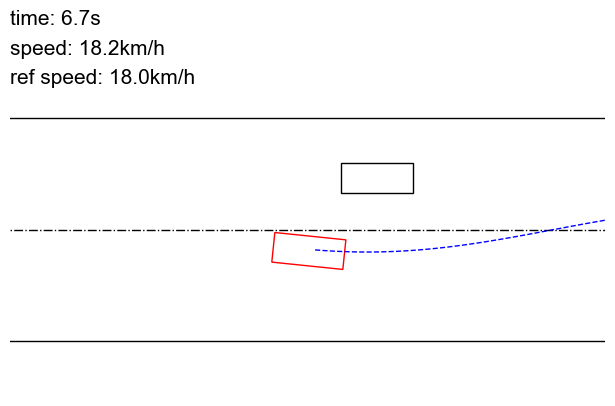

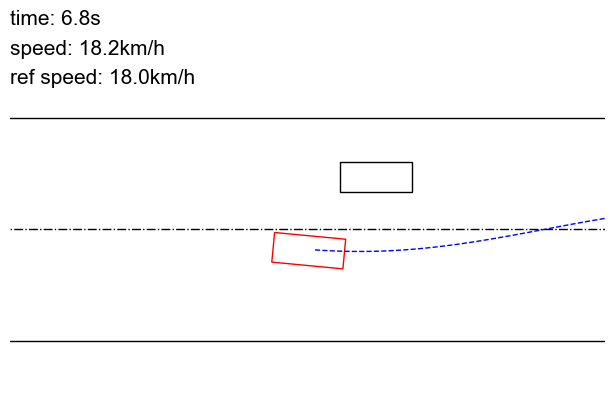

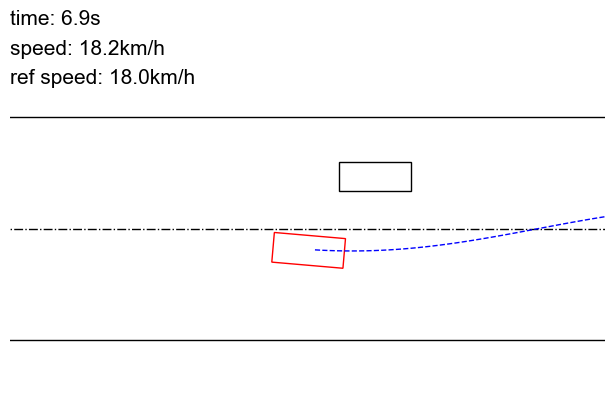

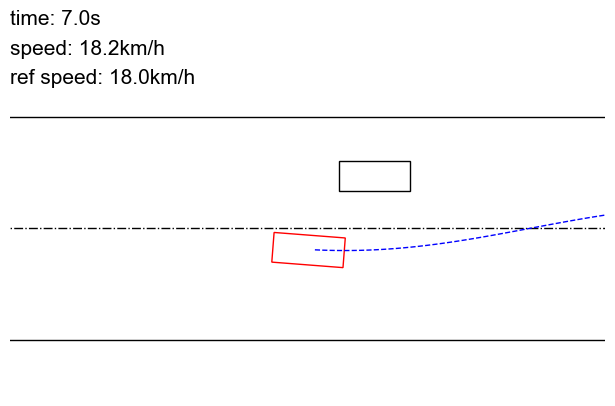

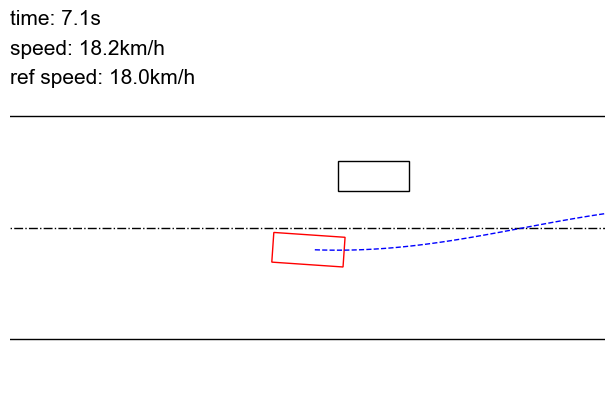

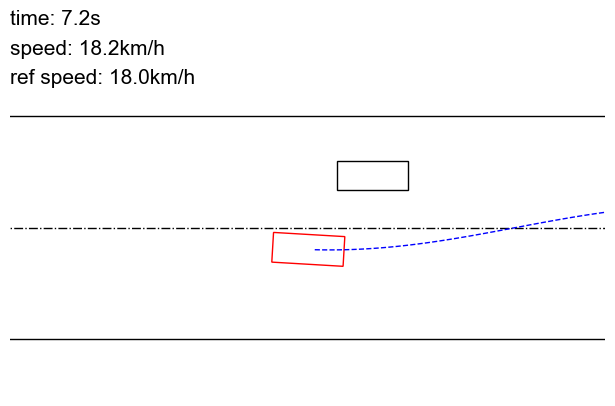

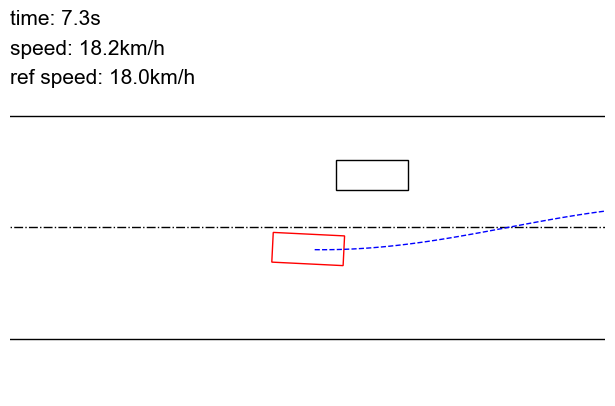

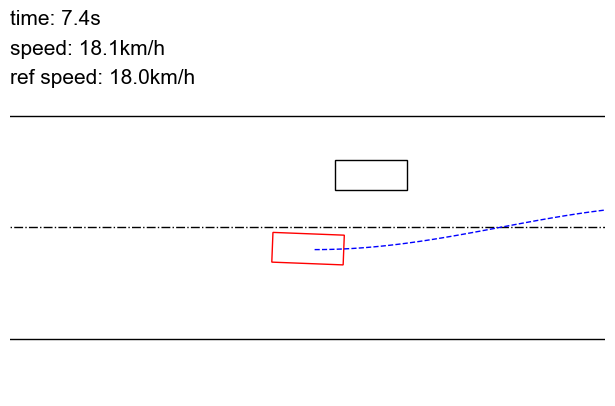

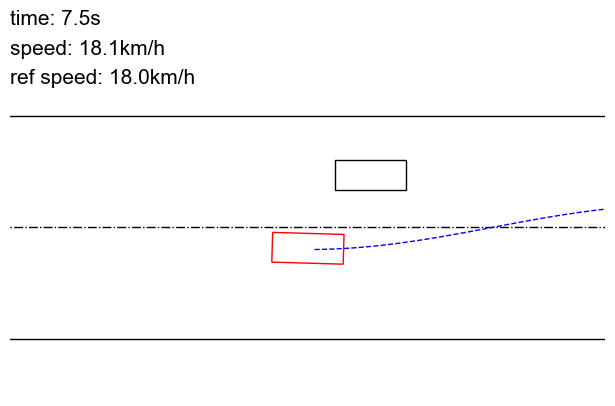

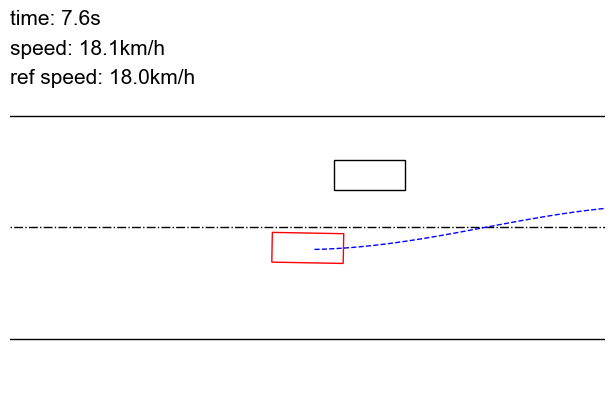

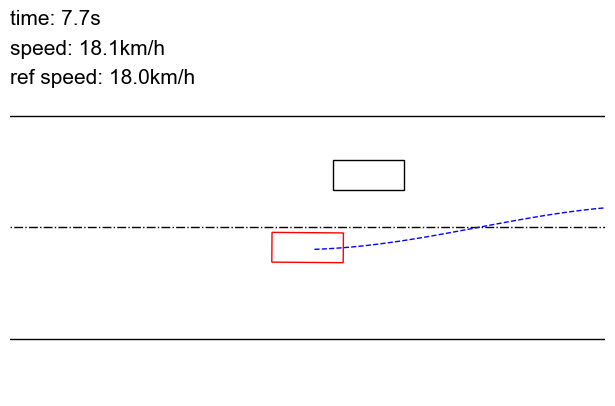

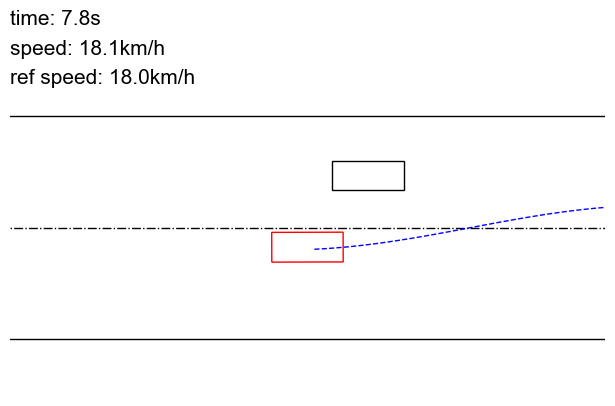

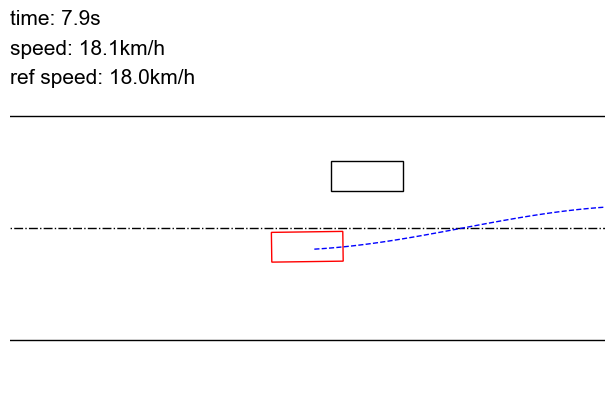

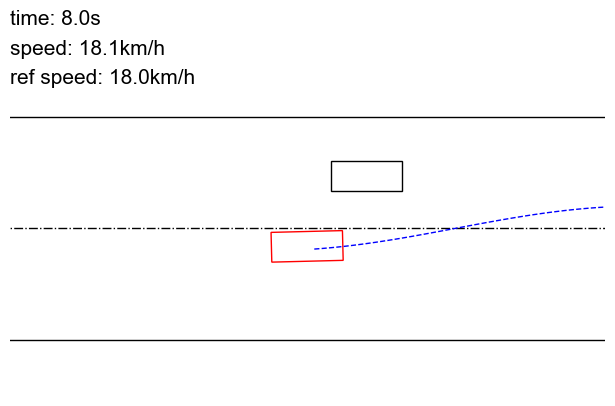

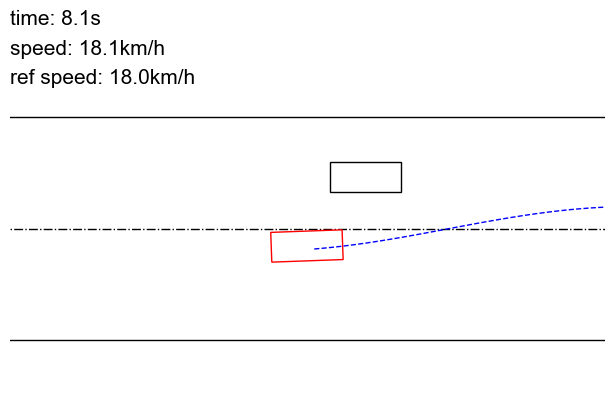

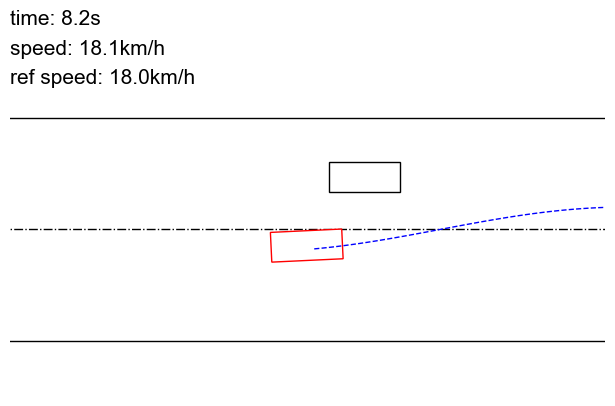

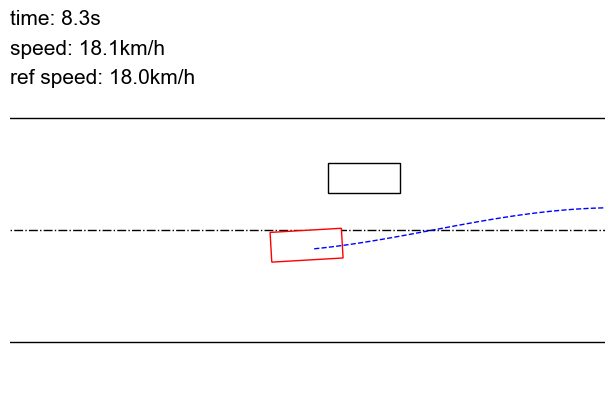

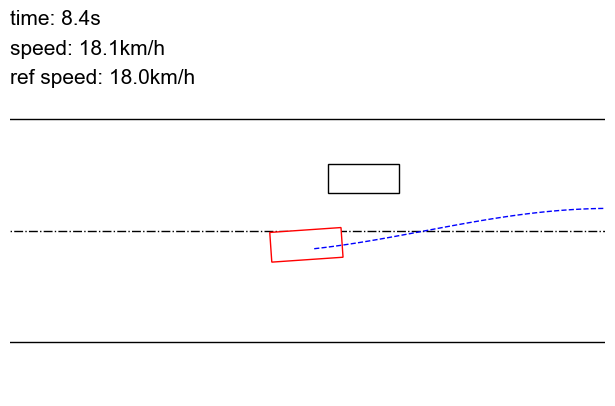

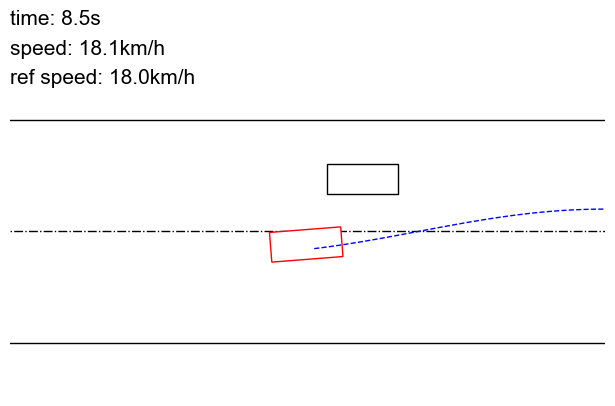

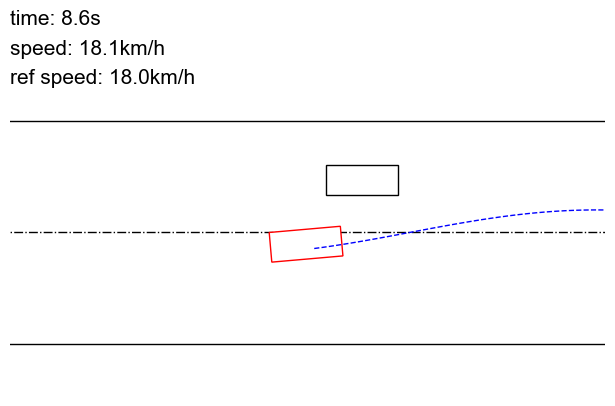

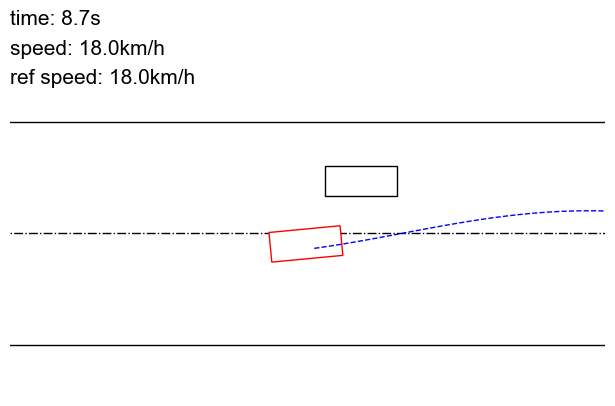

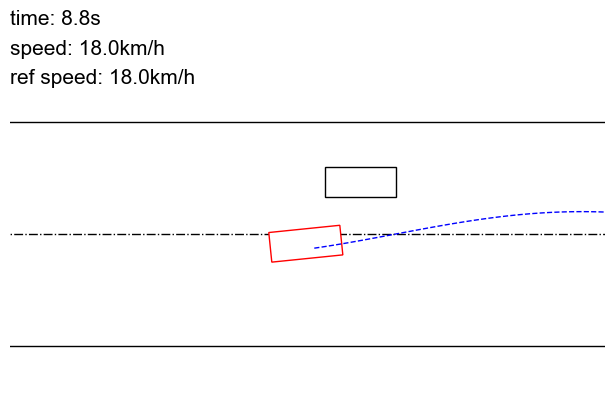

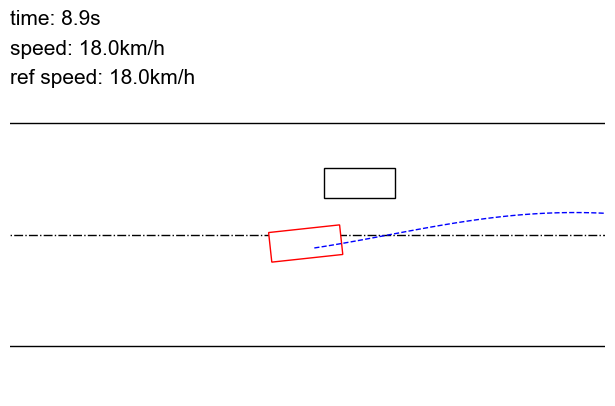

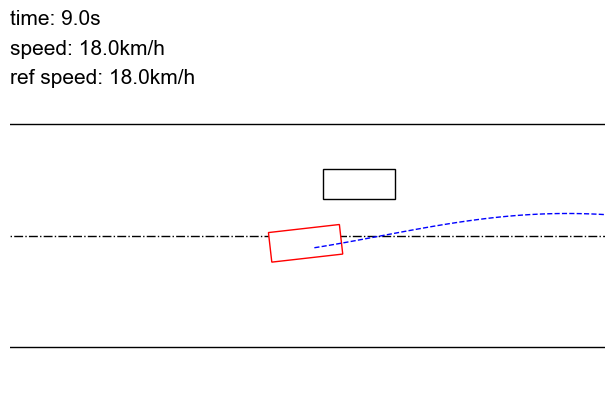

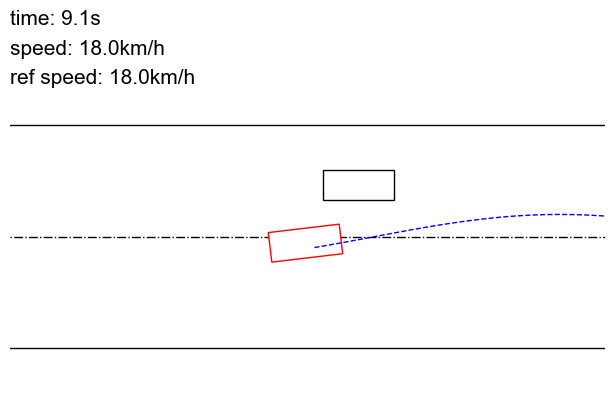

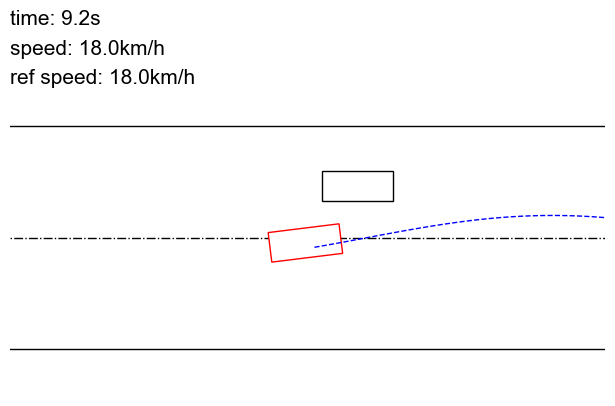

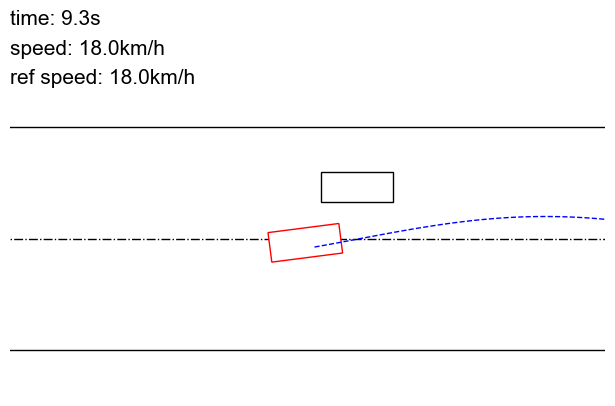

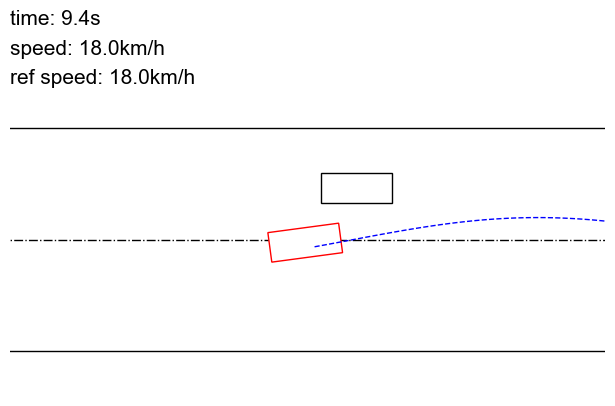

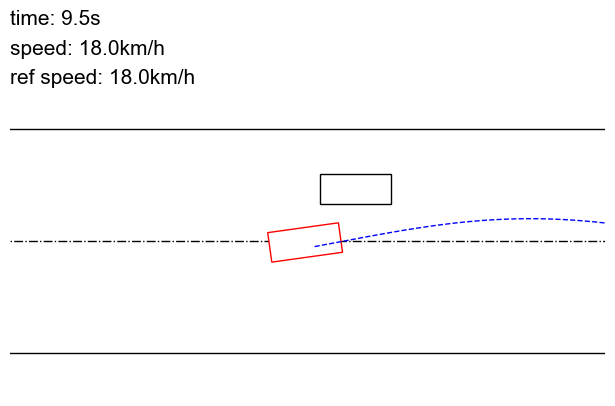

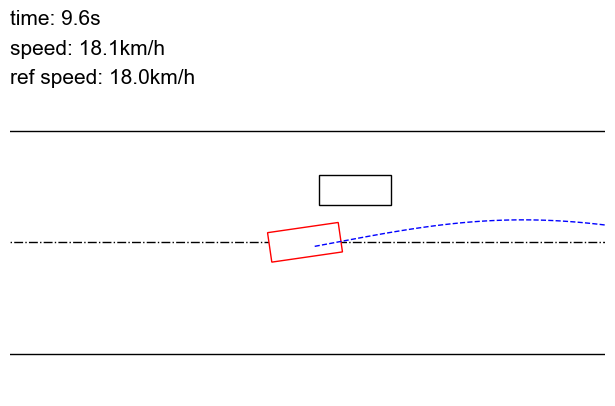

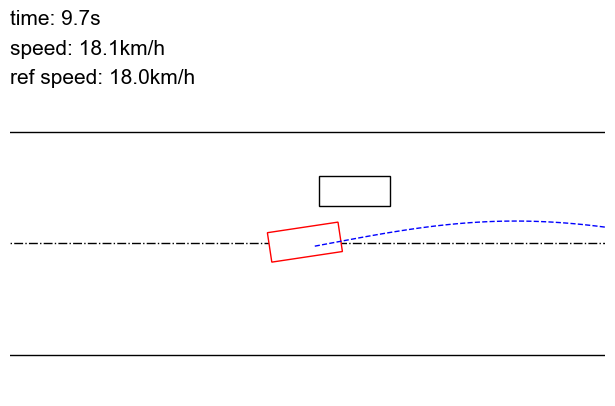

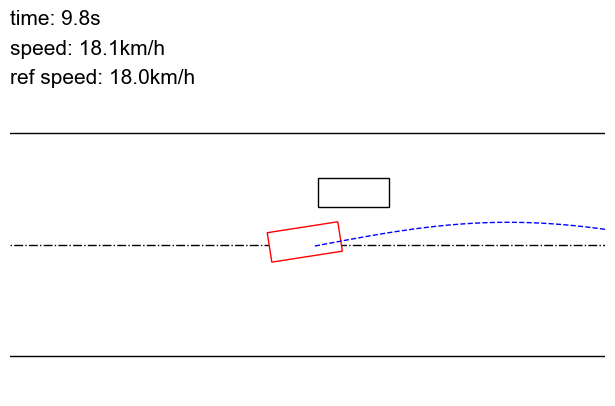

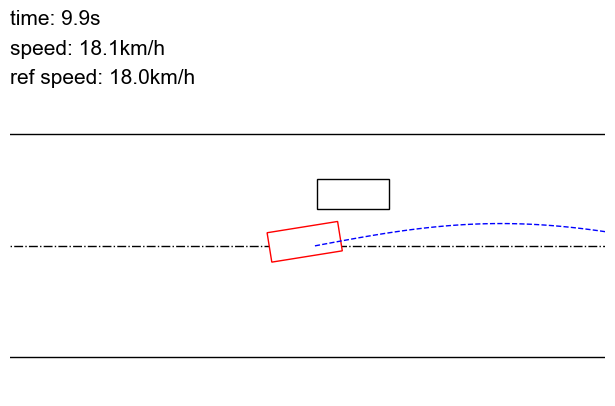

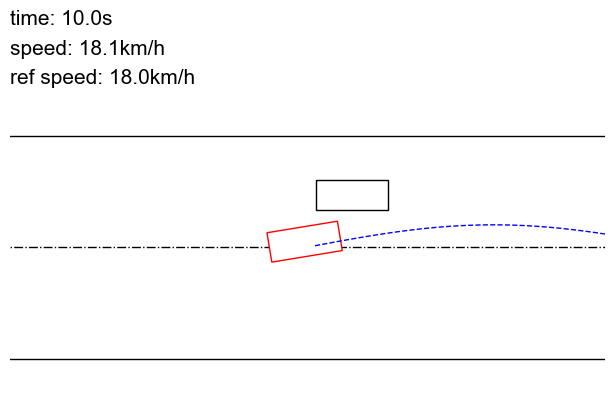

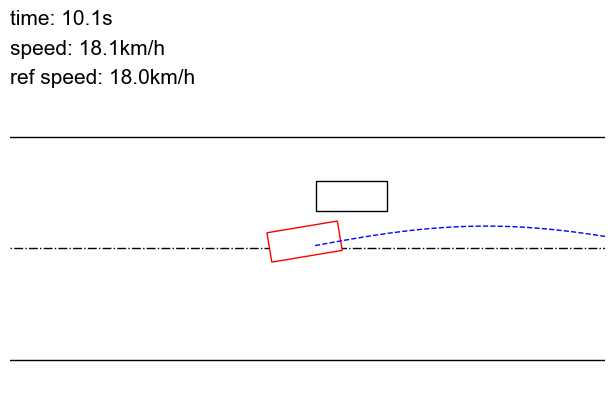

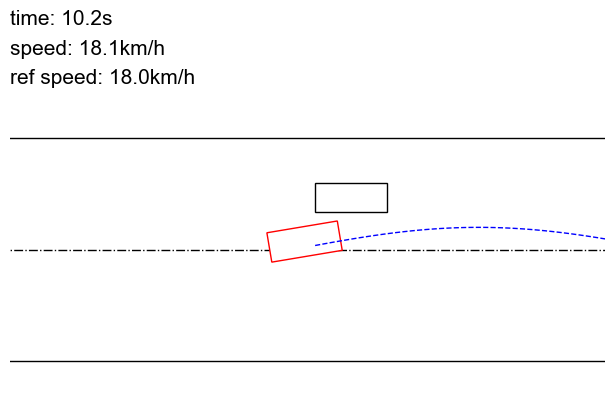

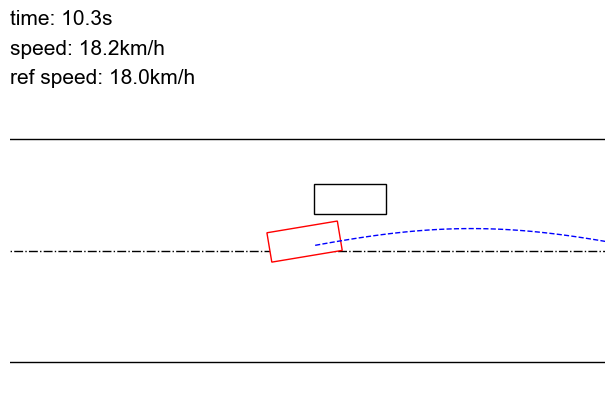

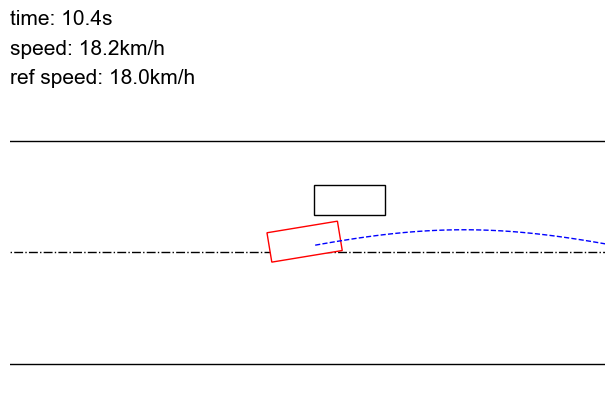

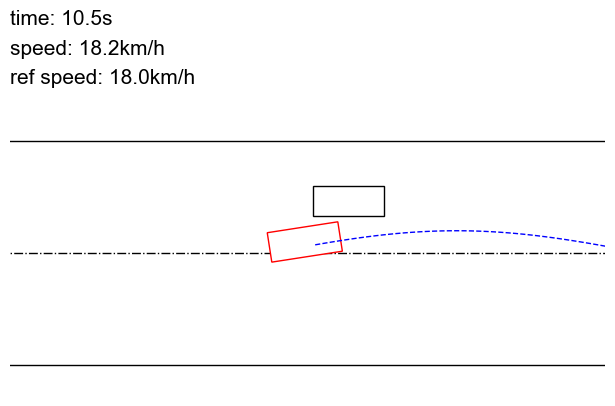

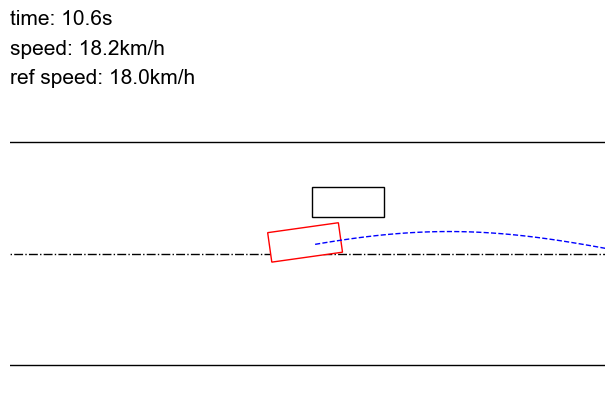

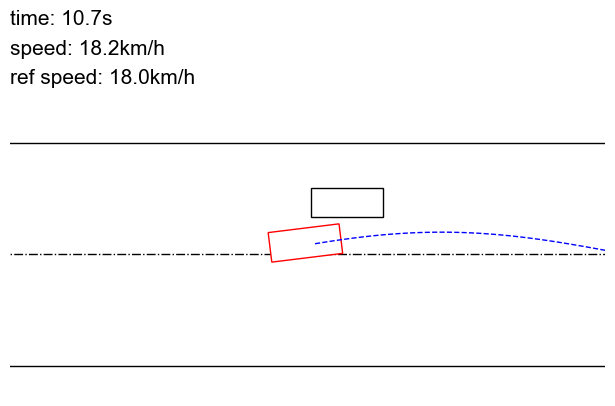

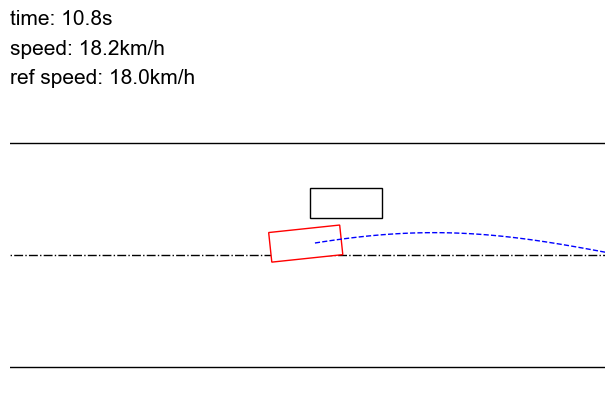

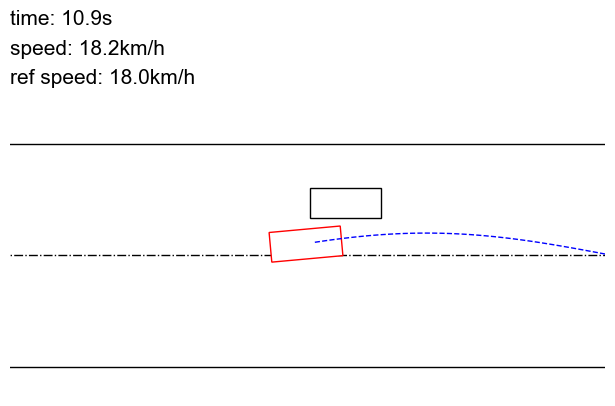

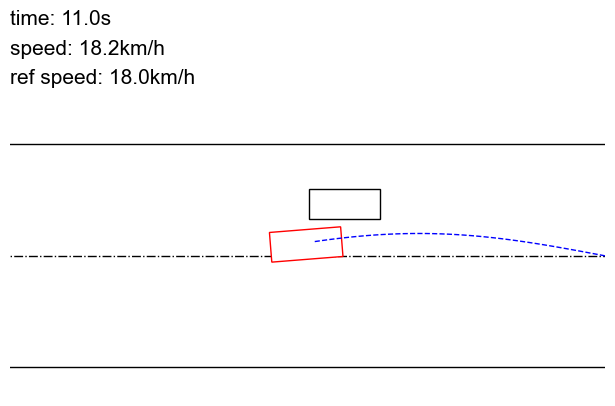

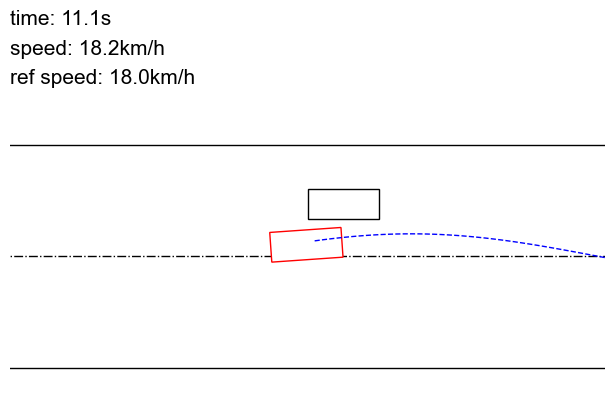

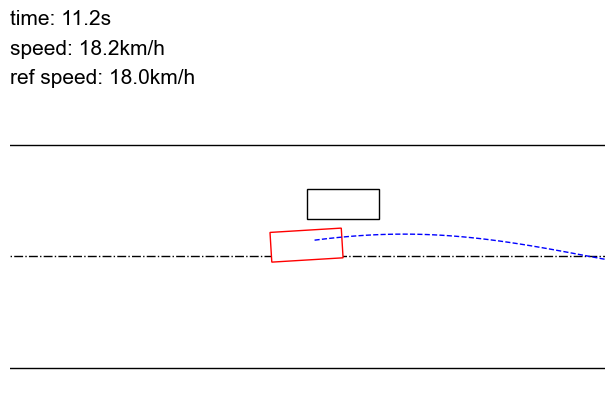

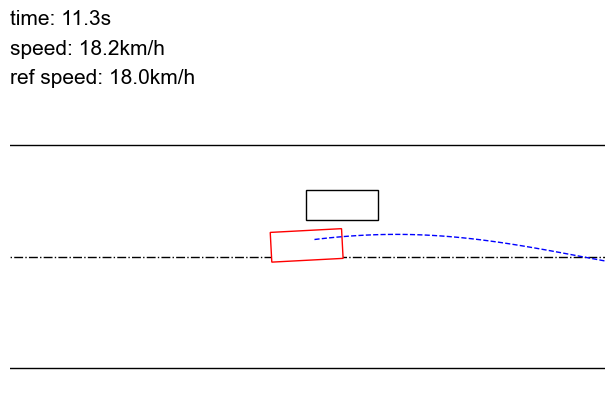

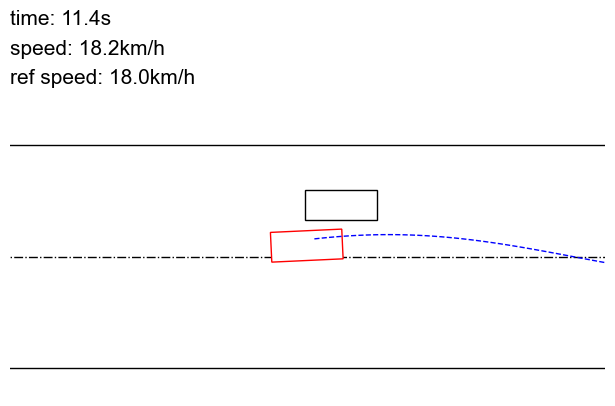

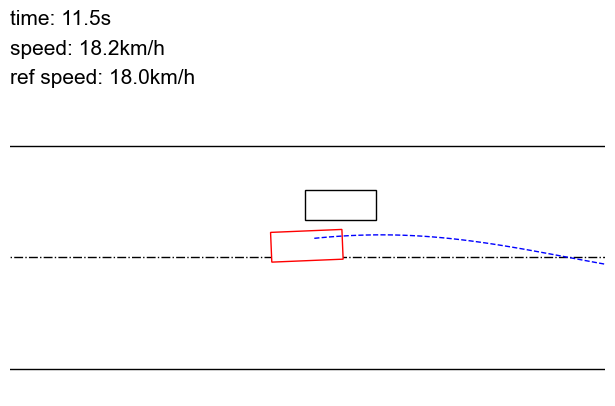

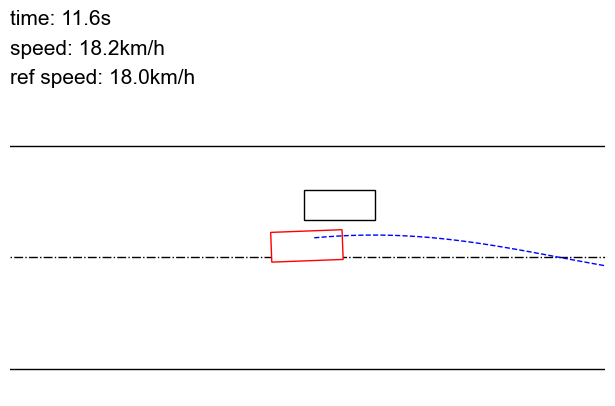

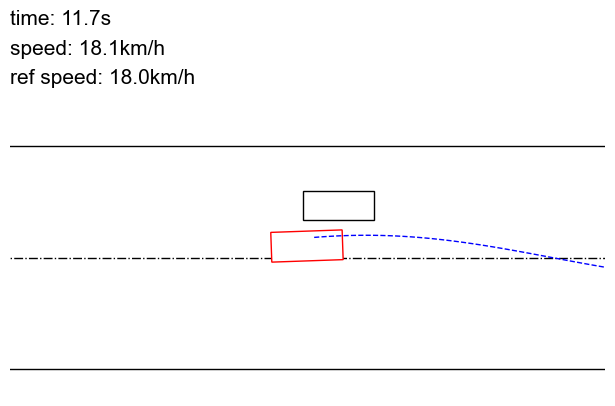

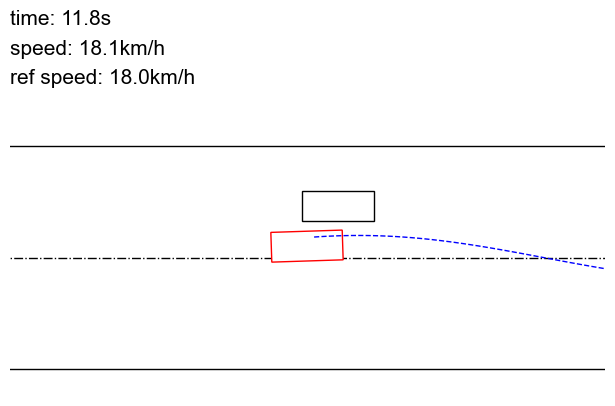

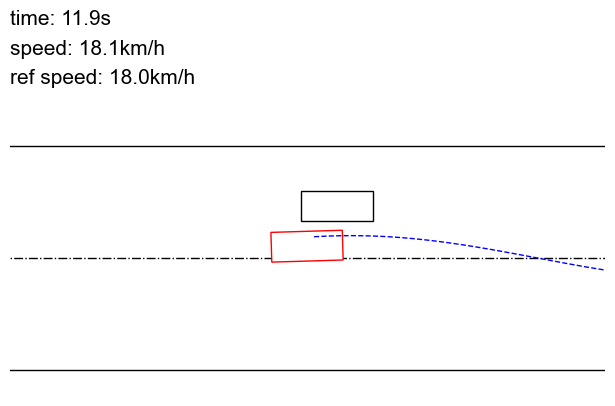

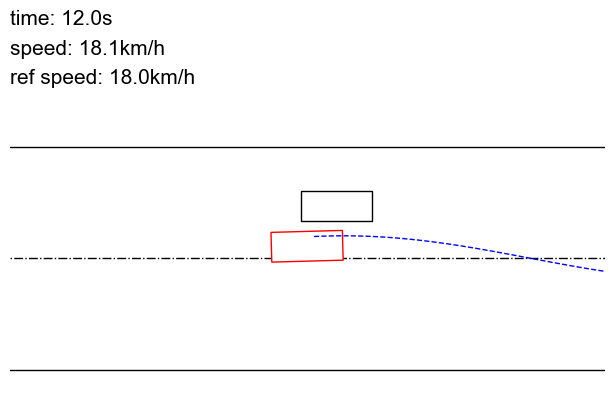

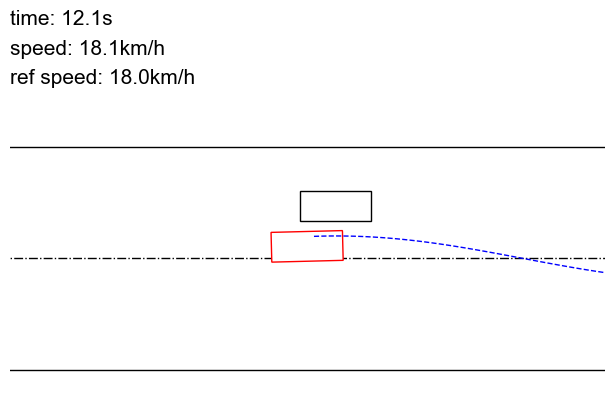

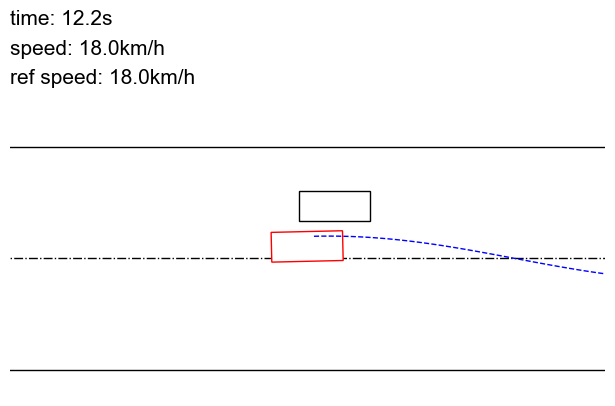

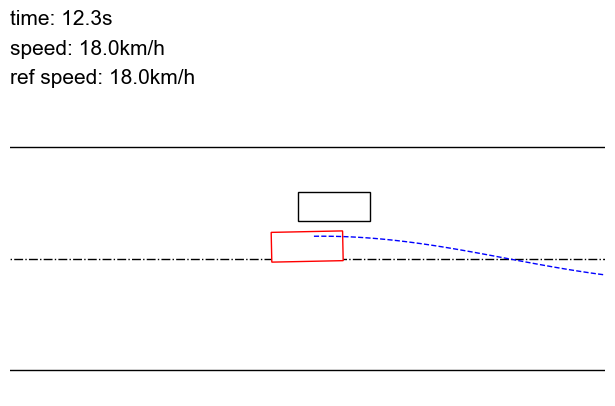

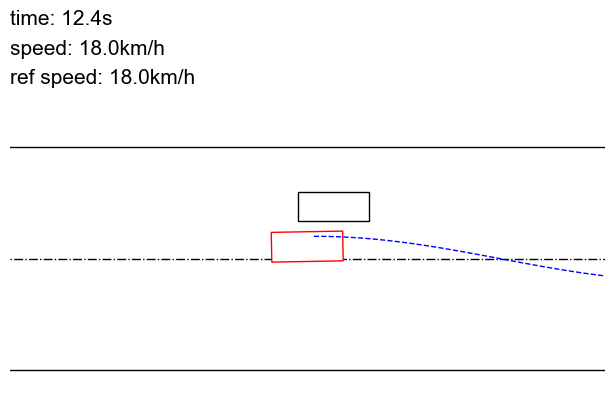

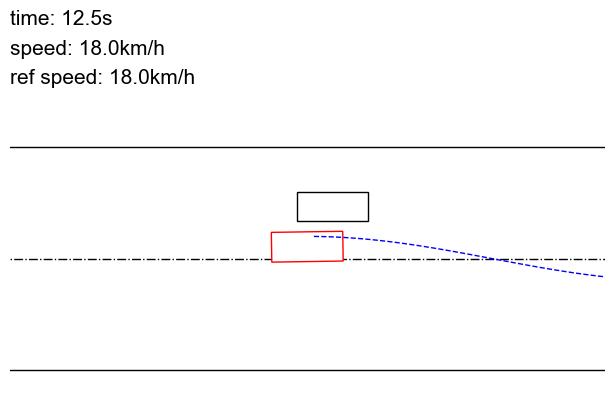

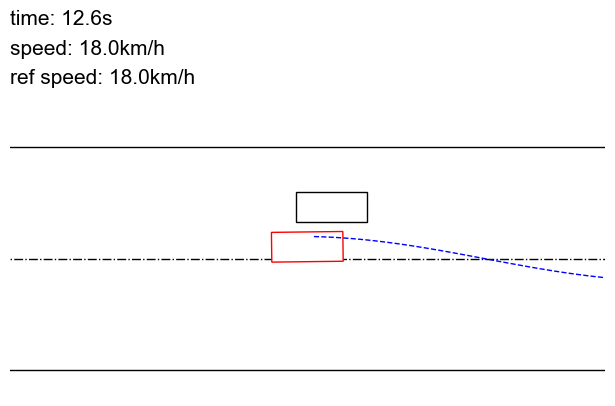

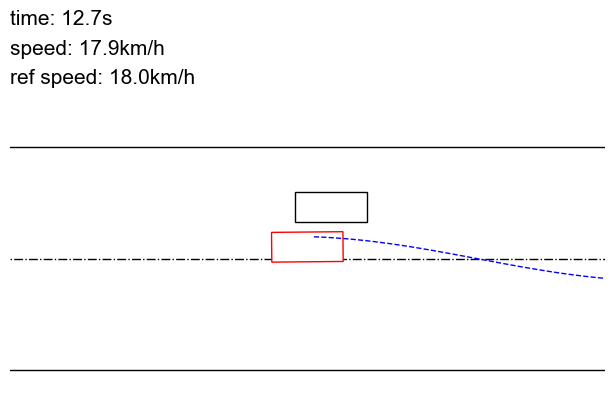

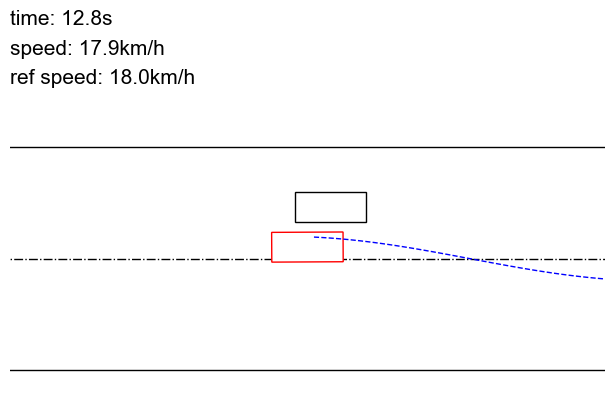

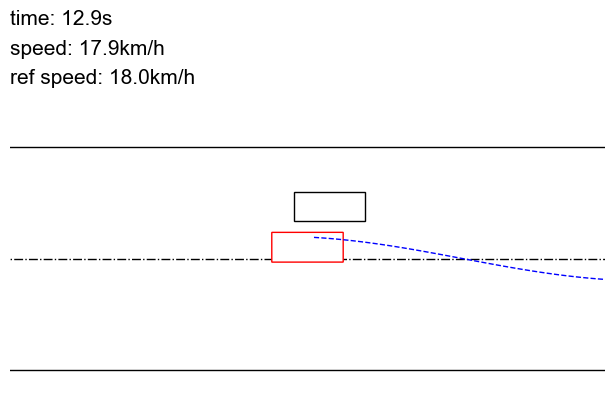

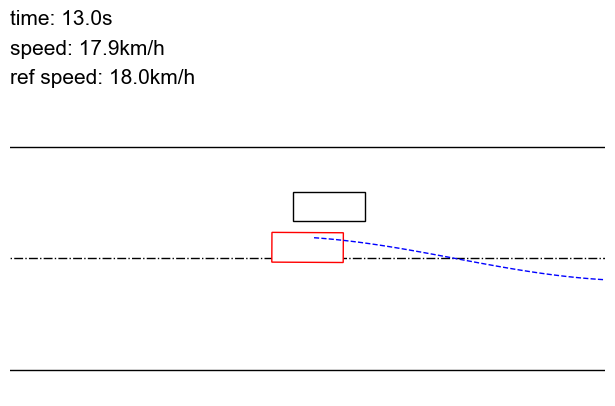

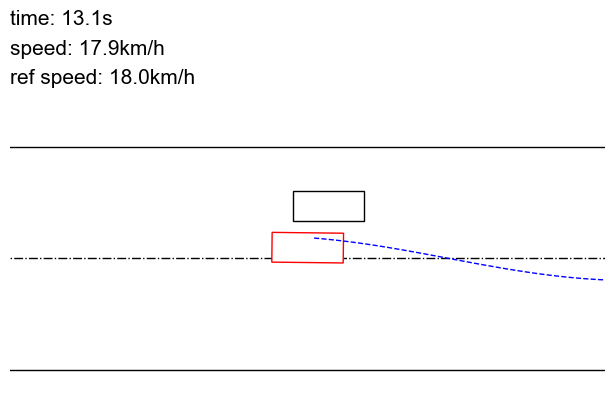

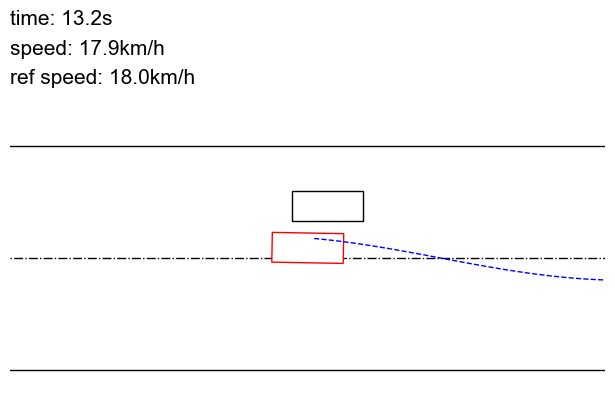

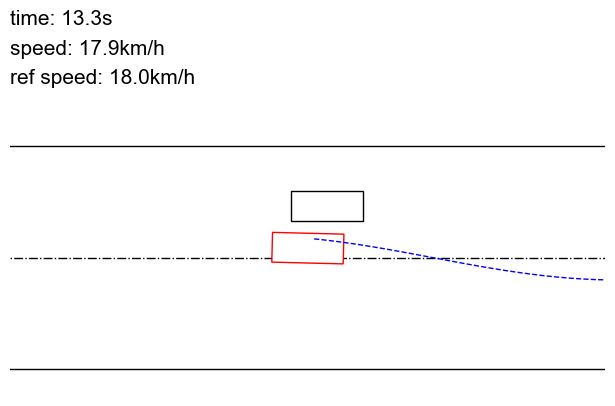

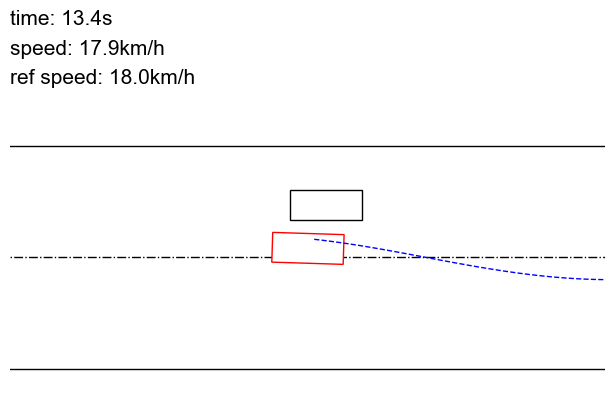

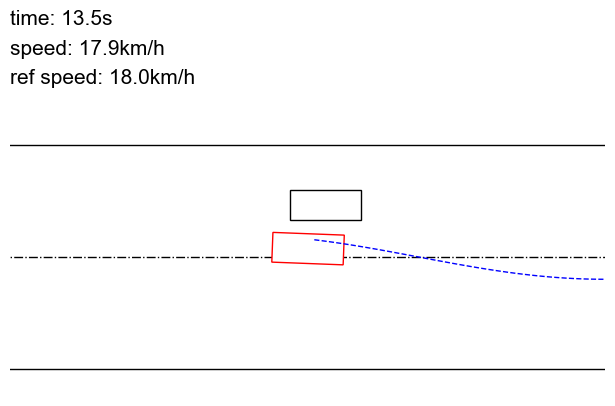

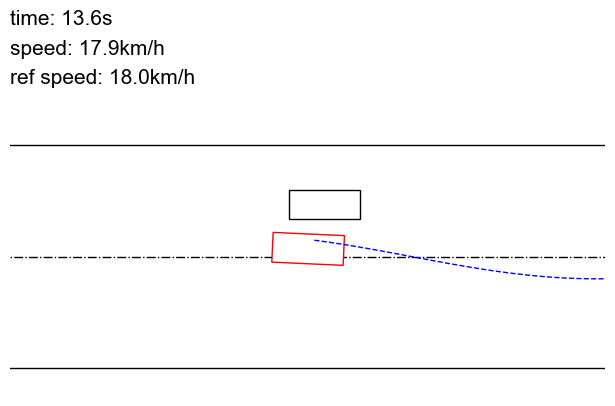

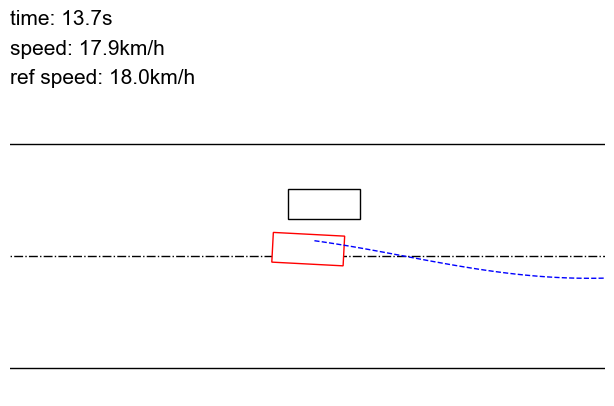

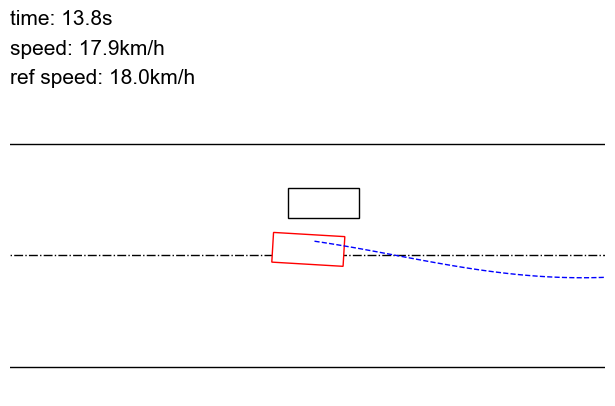

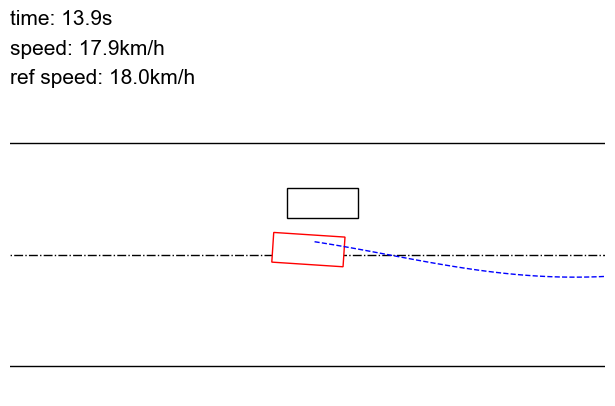

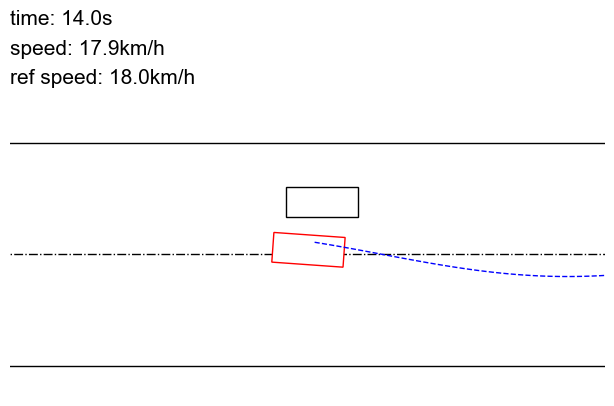

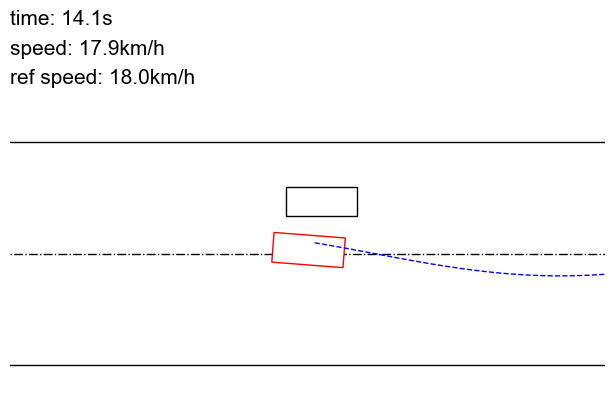

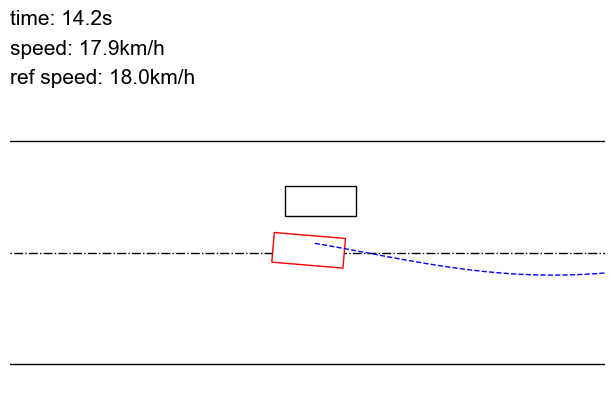

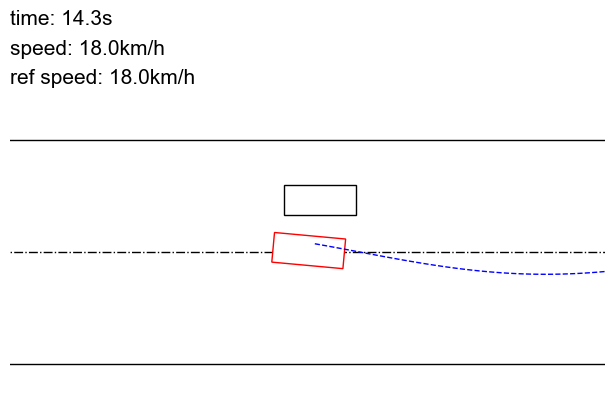

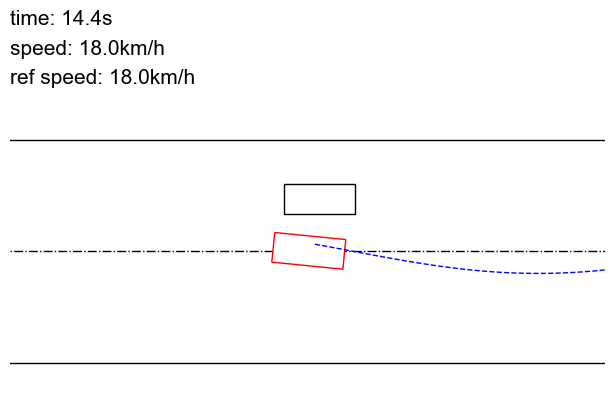

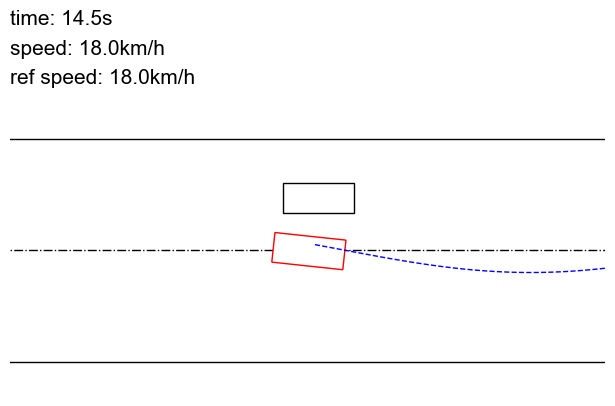

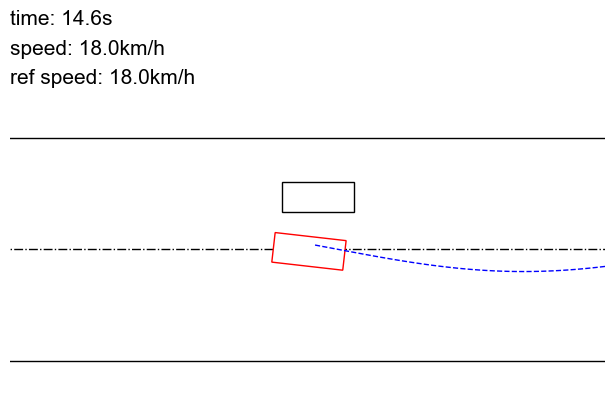

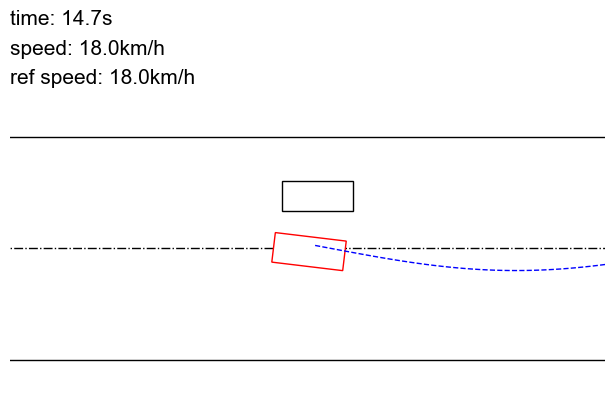

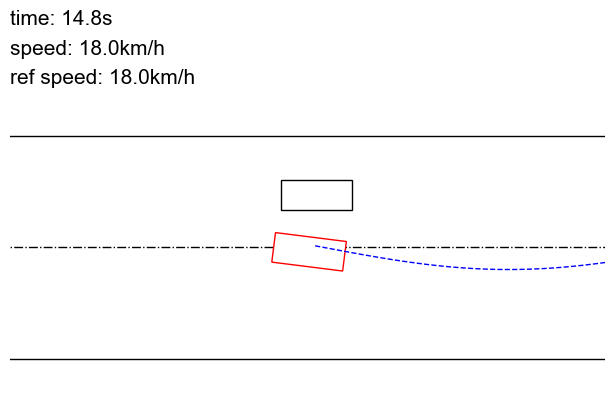

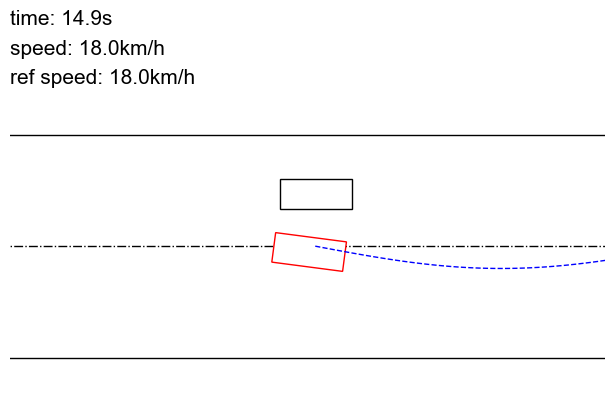

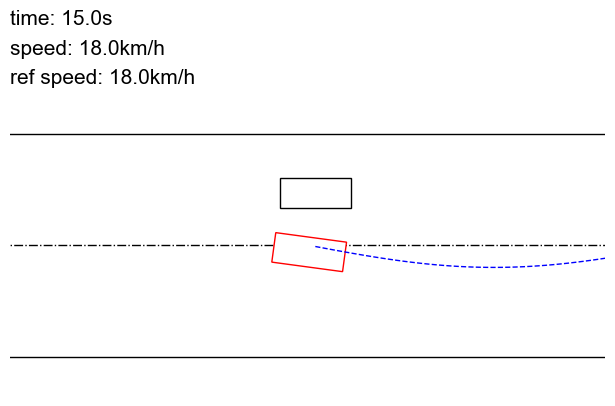

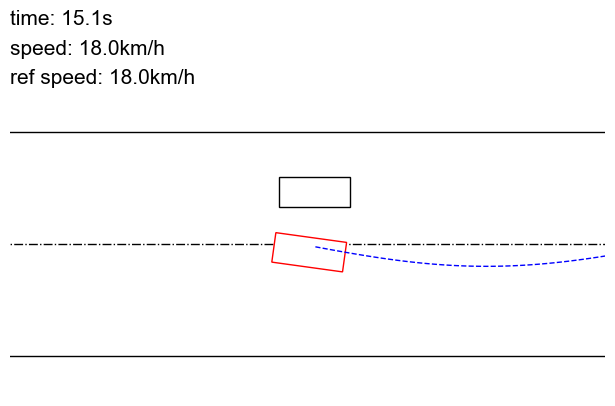

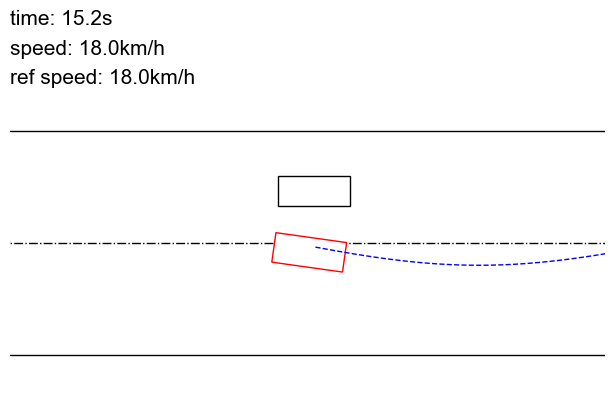

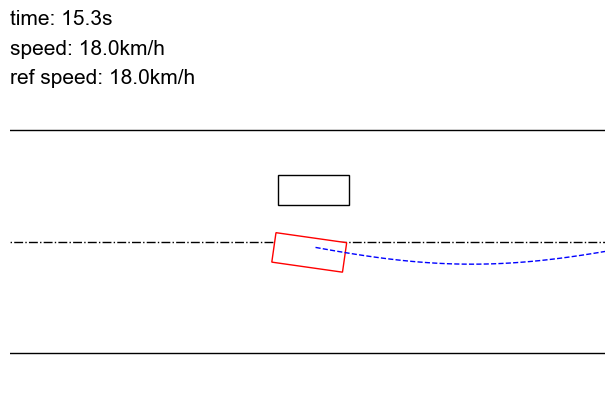

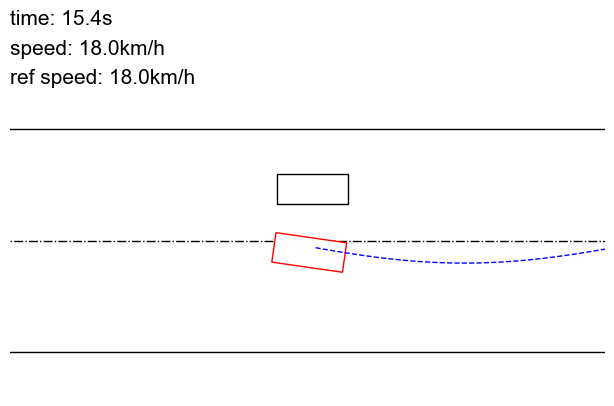

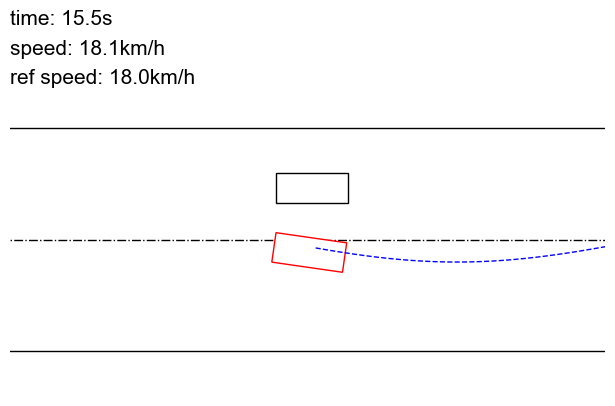

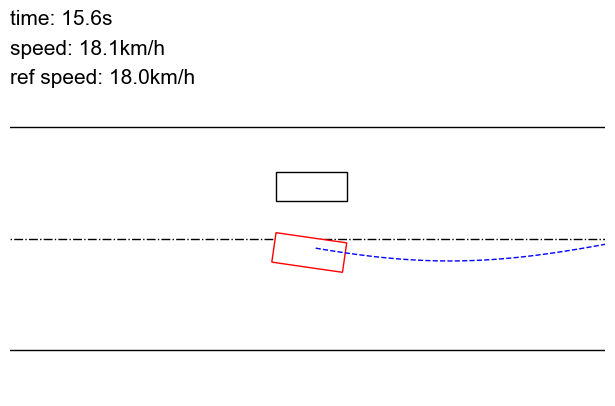

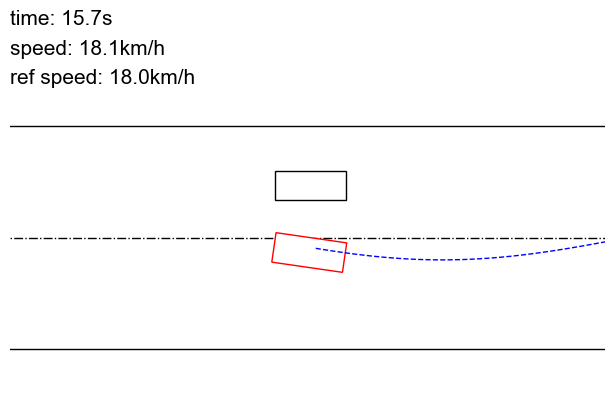

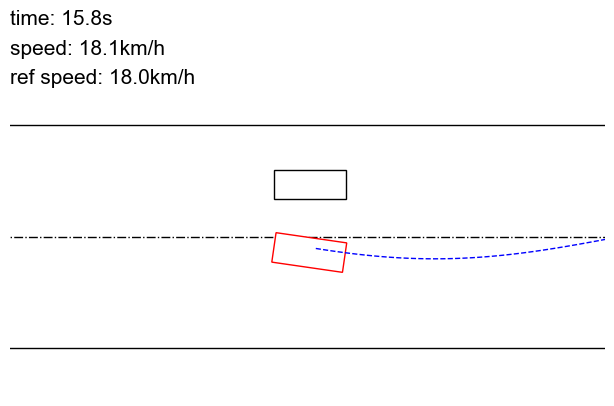

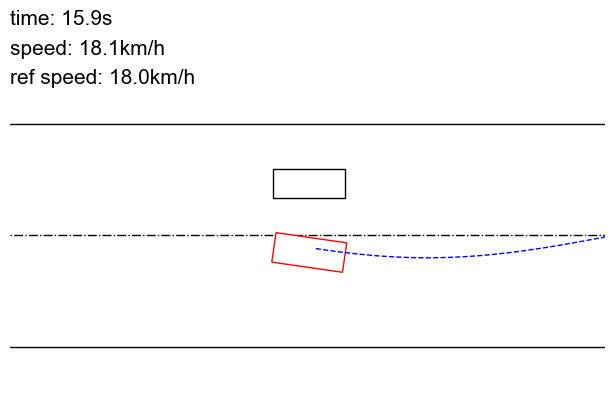

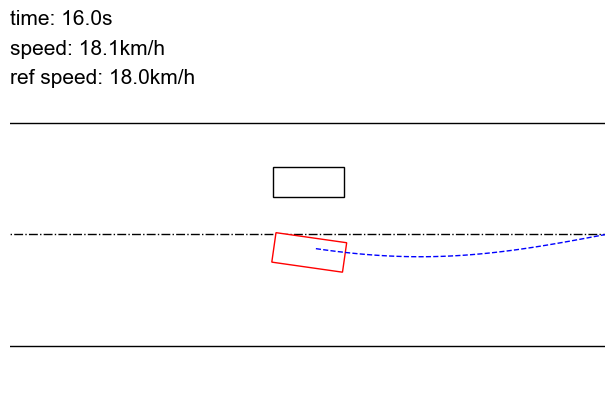

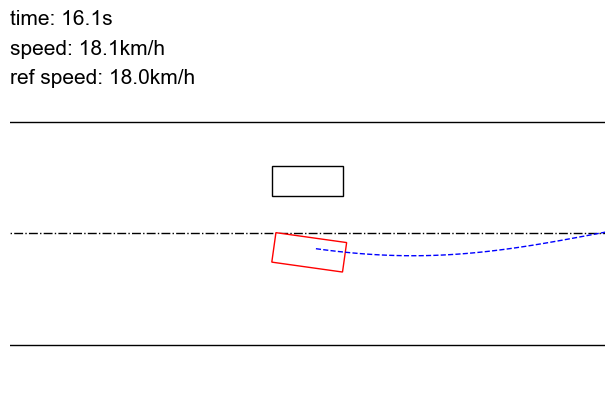

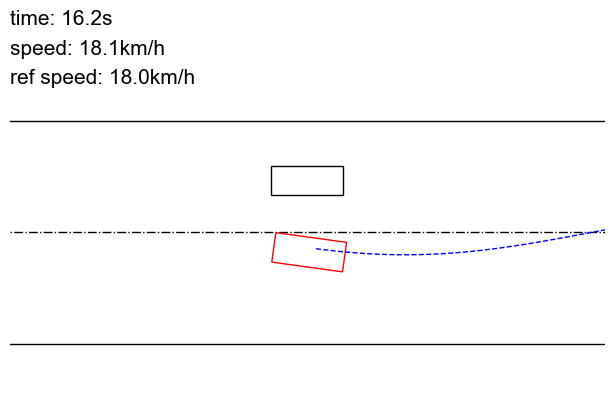

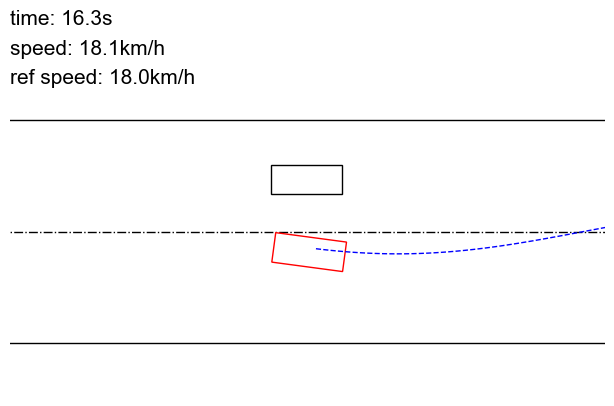

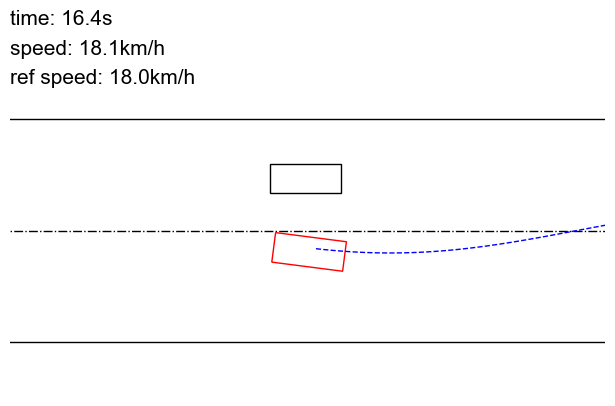

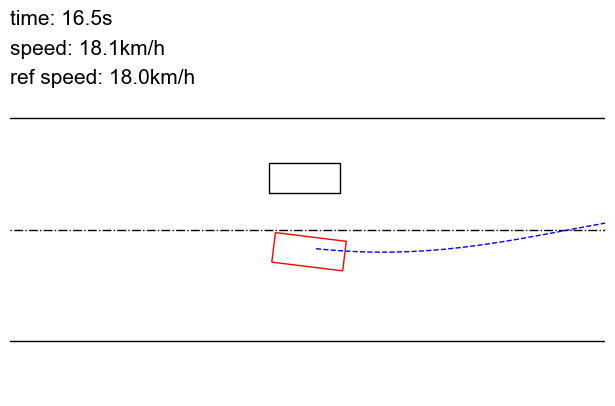

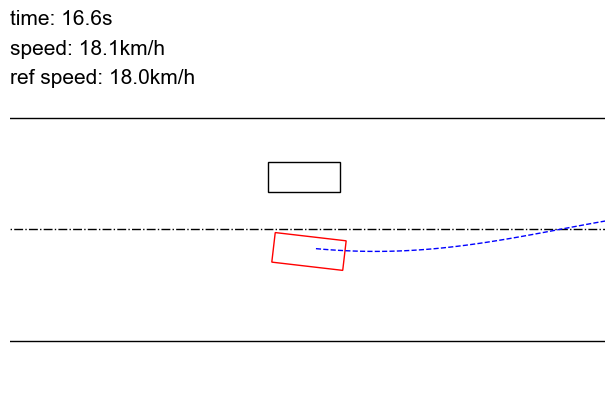

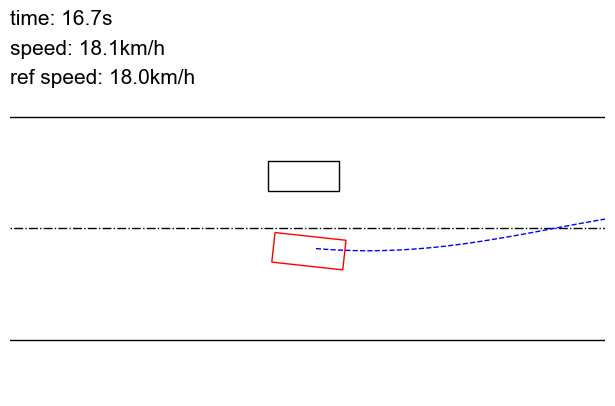

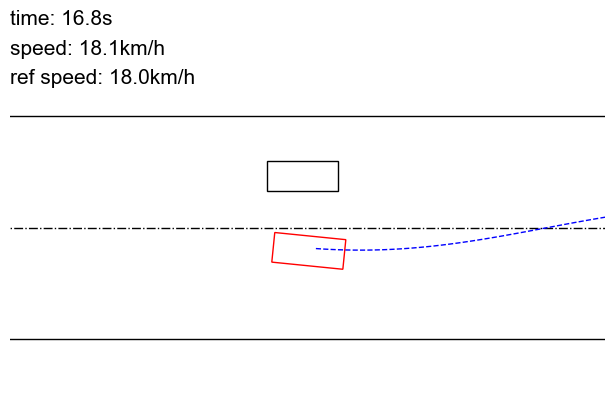

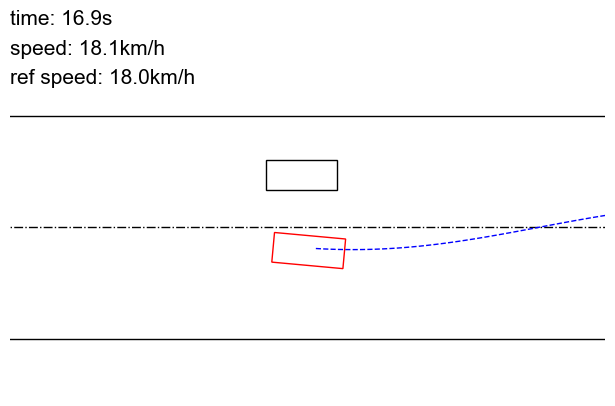

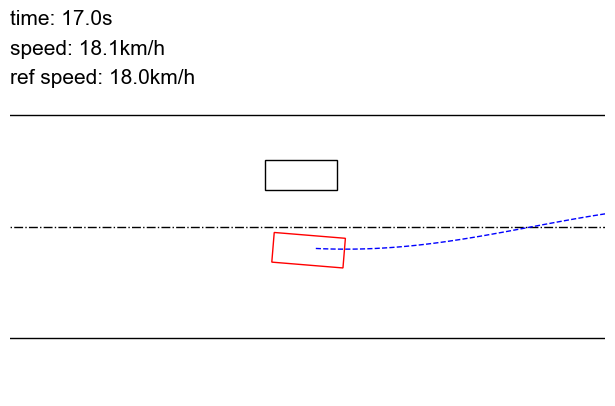

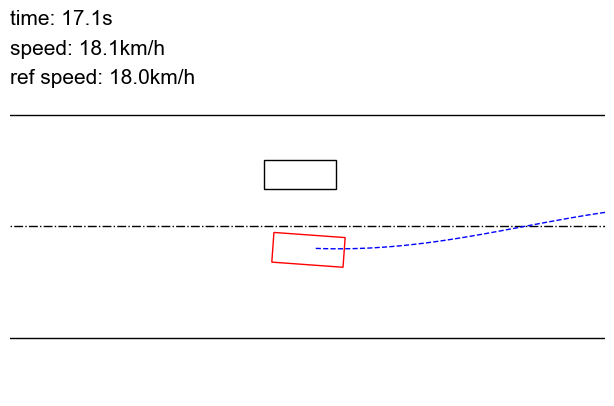

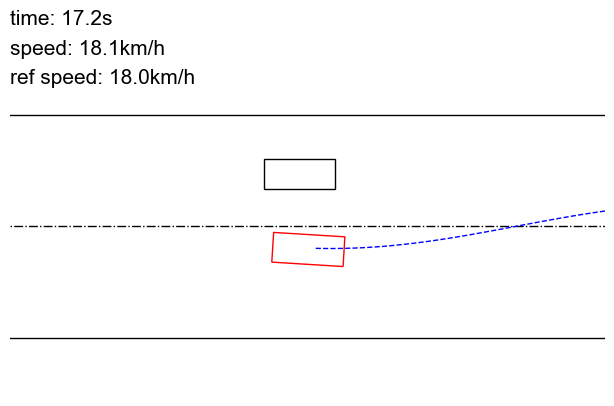

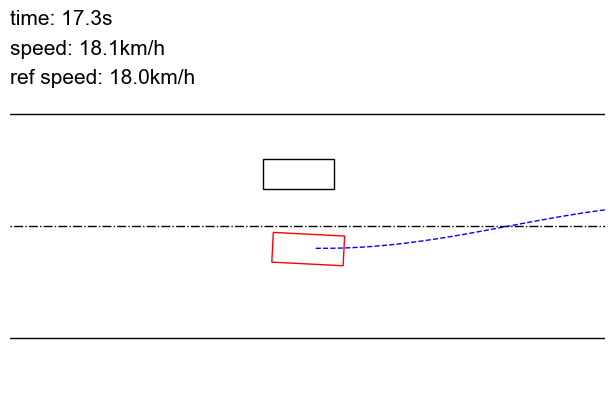

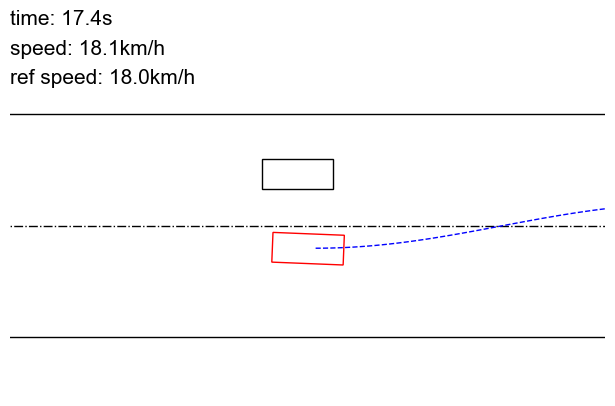

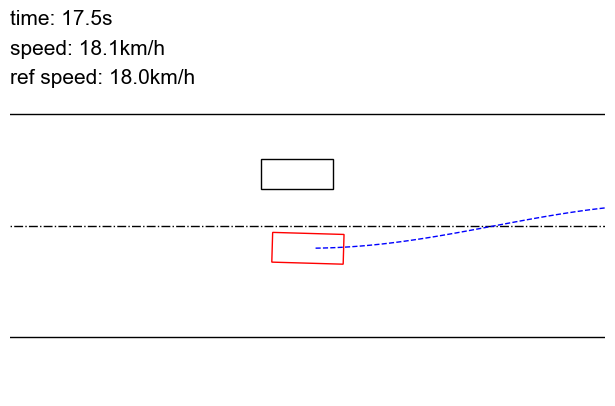

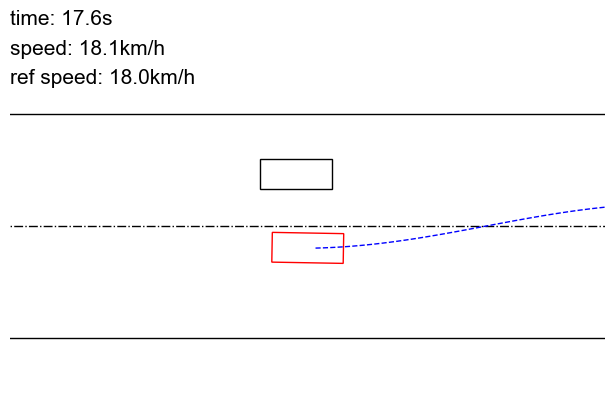

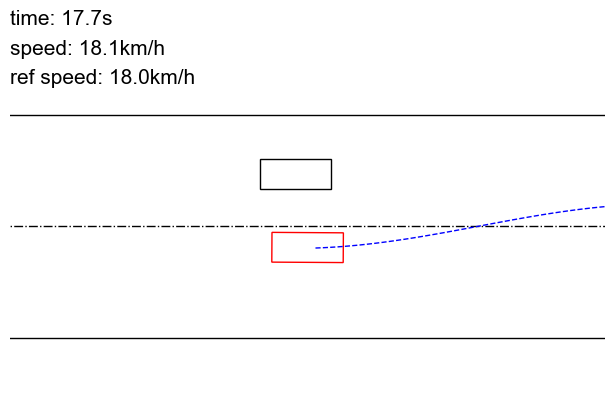

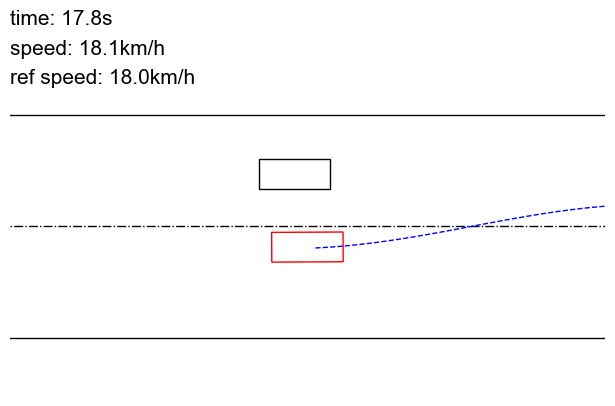

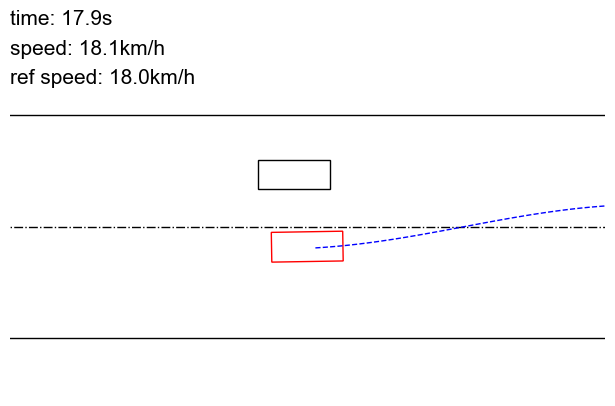

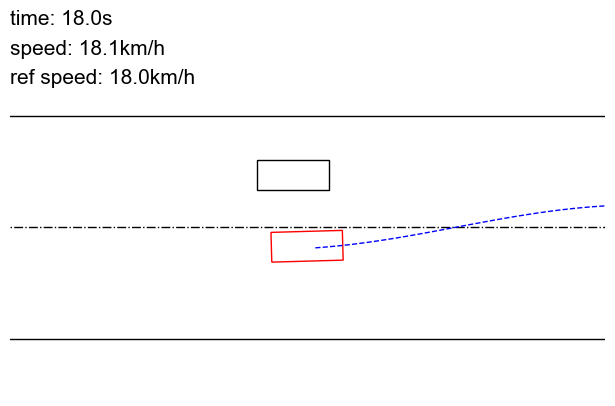

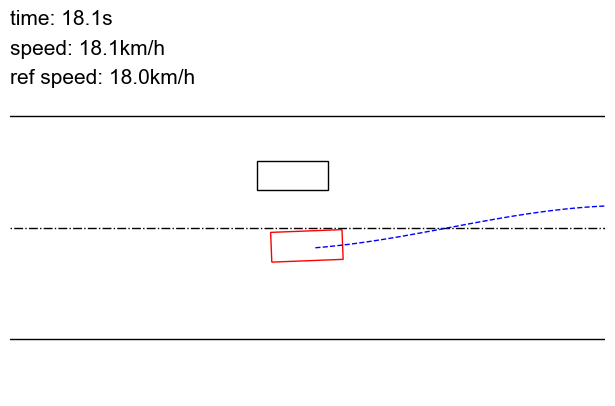

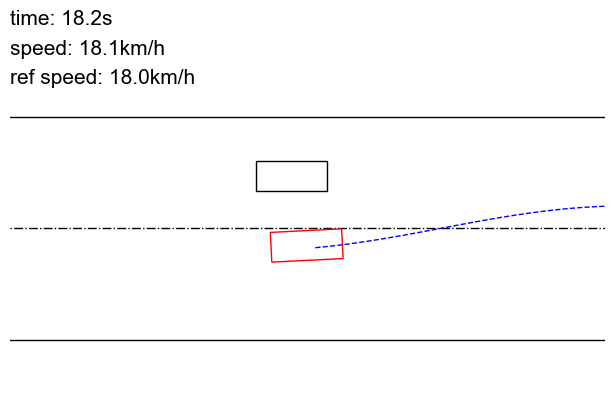

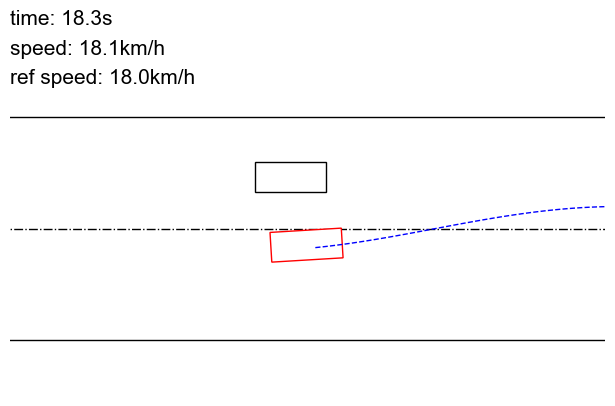

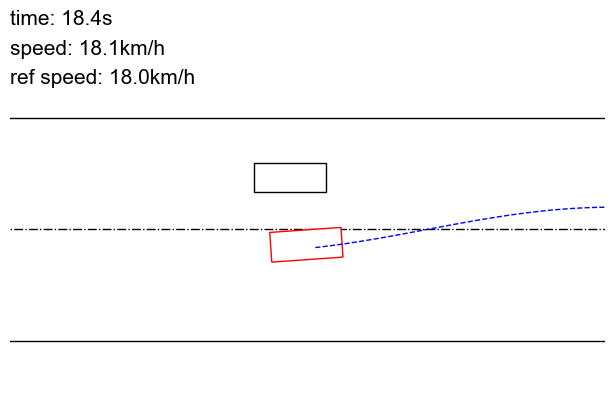

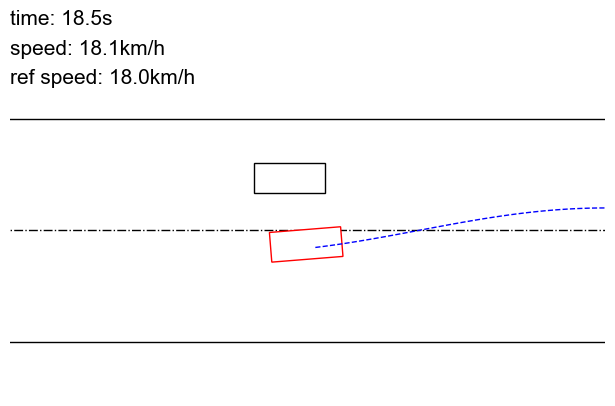

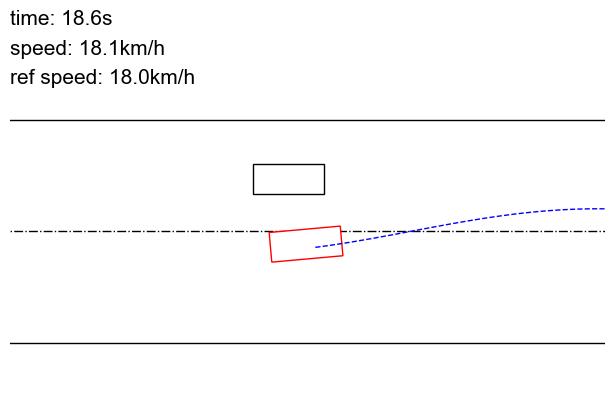

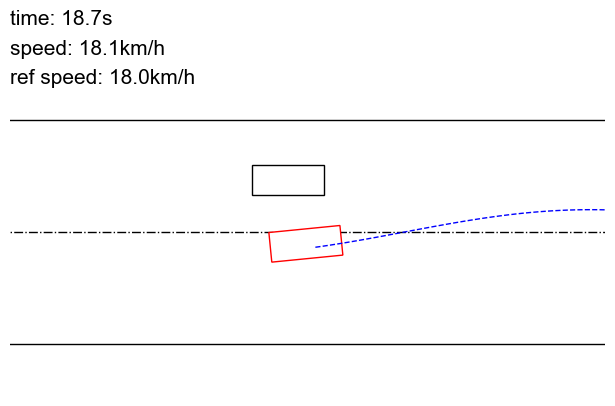

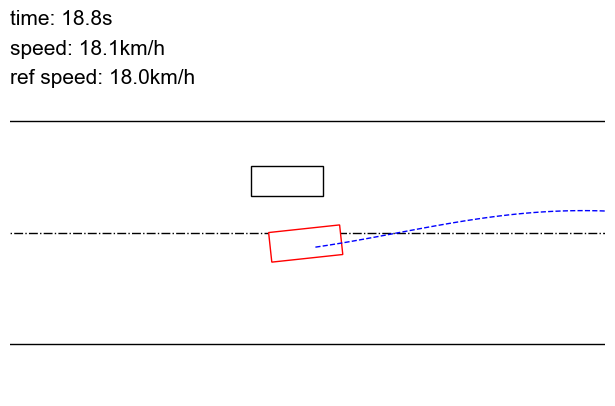

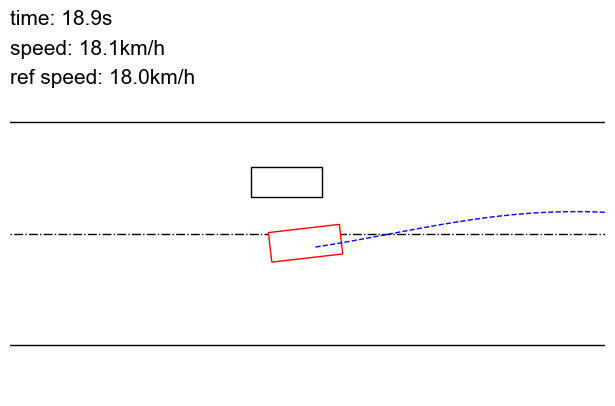

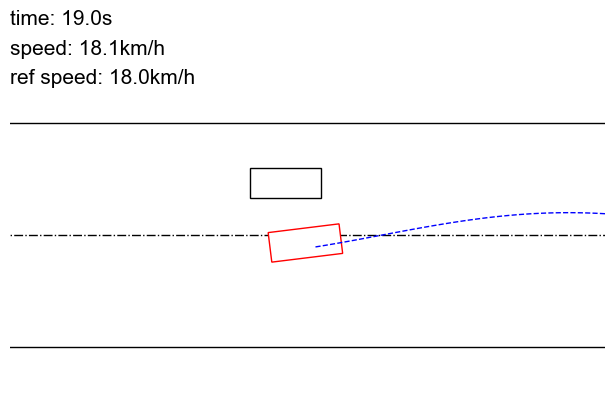

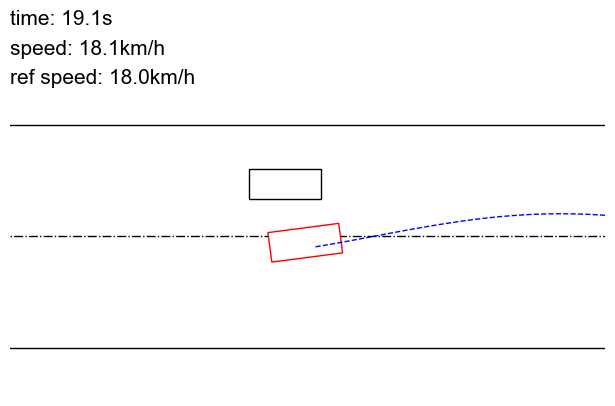

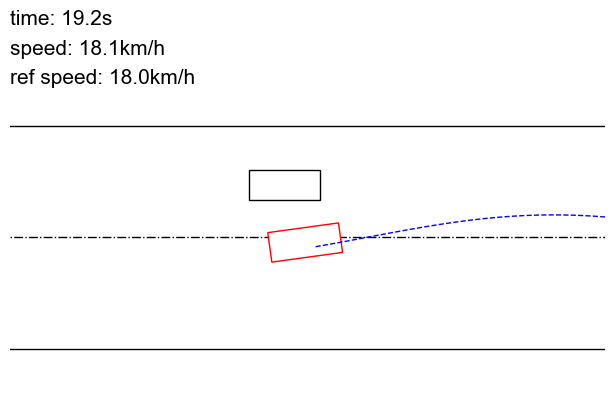

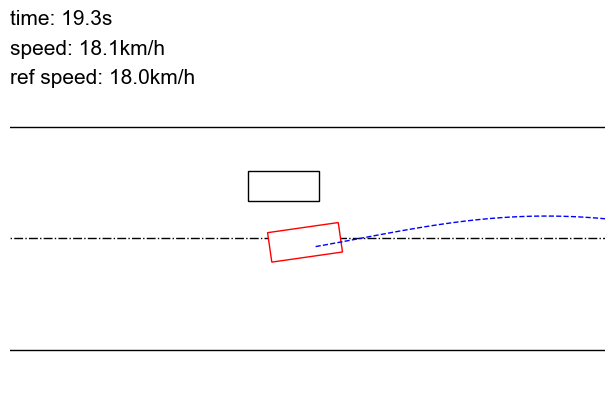

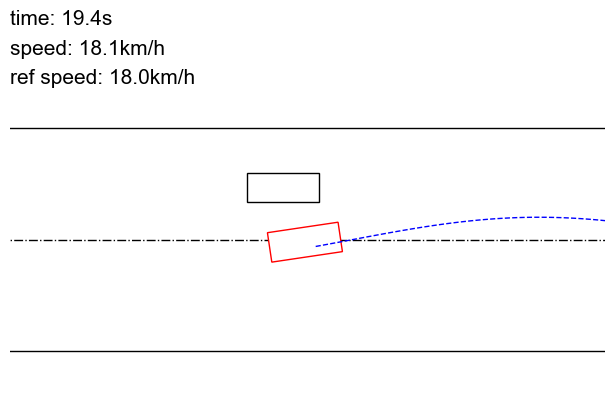

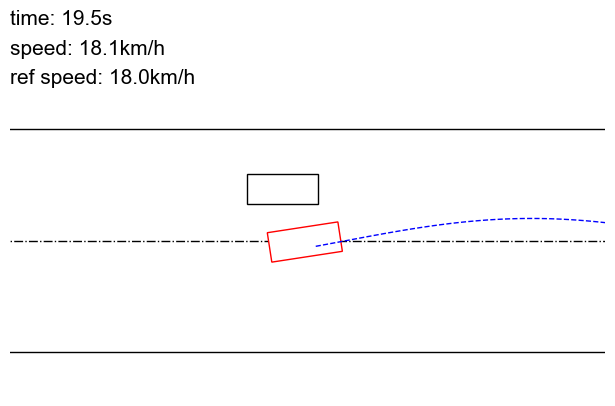

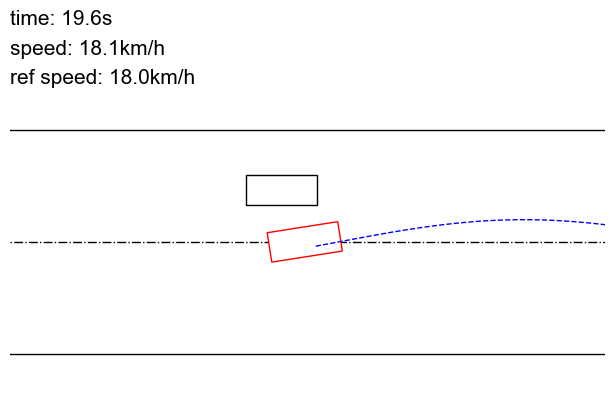

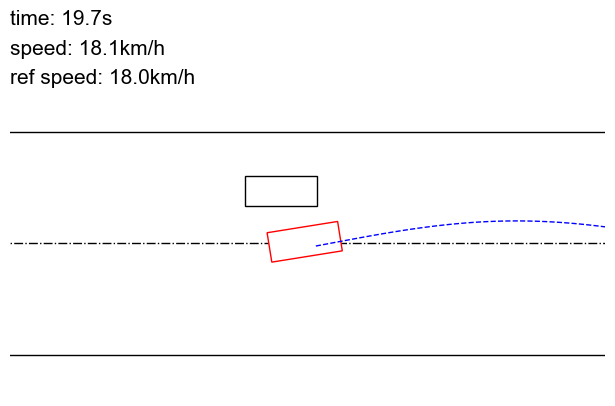

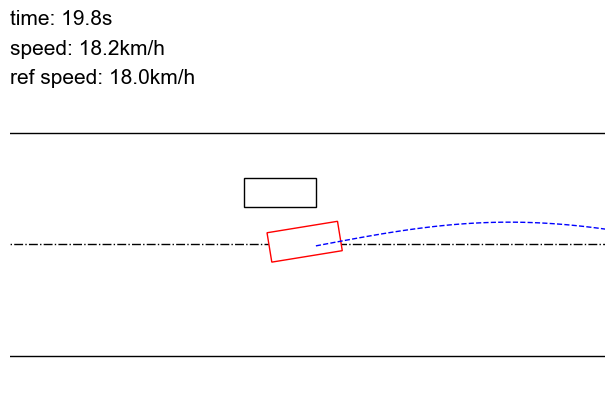

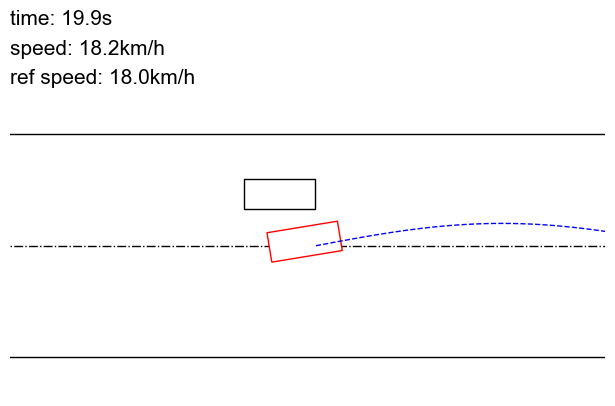

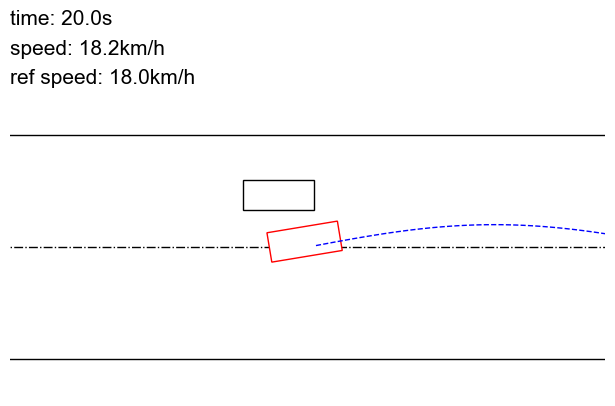

[11:40:52] test length mean: 200.0
[11:40:52] test return mean: -0.8879992961883545


In [2]:
env_name = "tracking"
log_dir = "02-18-23_00.35.25_DRPO_22" # fill in this
epoch = 460 # fill in this

# load cfg from the trained model
cfg = Config()

assert env_name == "tracking", 'This file is only for tracking env'
assert log_dir is not None, 'Must specify --run-dir'
run_dir = LOGS_DIR / log_dir
assert run_dir.is_dir(), f'Run directory does not exist: {run_dir}'

with (run_dir / 'config.json').open('r') as f:
    saved_cfg = json.load(f)
    assert env_name == saved_cfg["env_name"]
    cfg.update(saved_cfg)

cfg.alg_cfg.update(dict(mode='test'))
cfg.env_cfg.update(dict(render=True))

# Ensure all required arguments have been set
cfg.verify()
for attr in ('env_name', 'seed'):
    assert hasattr(cfg, attr), f'Config must specify {attr}'

# load model and set env
time_now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
test_log_dir = run_dir / 'test-{}'.format(time_now)
test_log_dir.mkdir(exist_ok=True, parents=True)

print(f'Test log directory: {test_log_dir}')

# initialize tester and run evaluation
tester = Tester(cfg, test_log_dir, epoch)
test_traj, info_traj = tester.run_evaluation()

In [3]:
# get necessary data trajectories
traj_len = len(test_traj[0].get("actions"))
time_steps = np.arange(traj_len) * 0.1

surrs_states = np.array(info_traj[0]["surr_state"], dtype=np.float32)
states = np.array(info_traj[0]["state"], dtype=np.float32)
actions = np.array(test_traj[0].get("actions").cpu().numpy(), dtype=np.float32)
constraints = np.array(info_traj[0]["constraint_value"], dtype=np.float32)
video = np.array(info_traj[0]["img"], dtype=np.float32) / 255.0

ego_pos = states[:, :2]
ref_pos = np.array(info_traj[0]["ref_points"], dtype=np.float32)[:, 0, :2]
surrs_poses = surrs_states[:, :, :2]

# scale actions with pi/6 and 3
actions[:, 0] *= np.pi / 6
actions[:, 1] *= 3

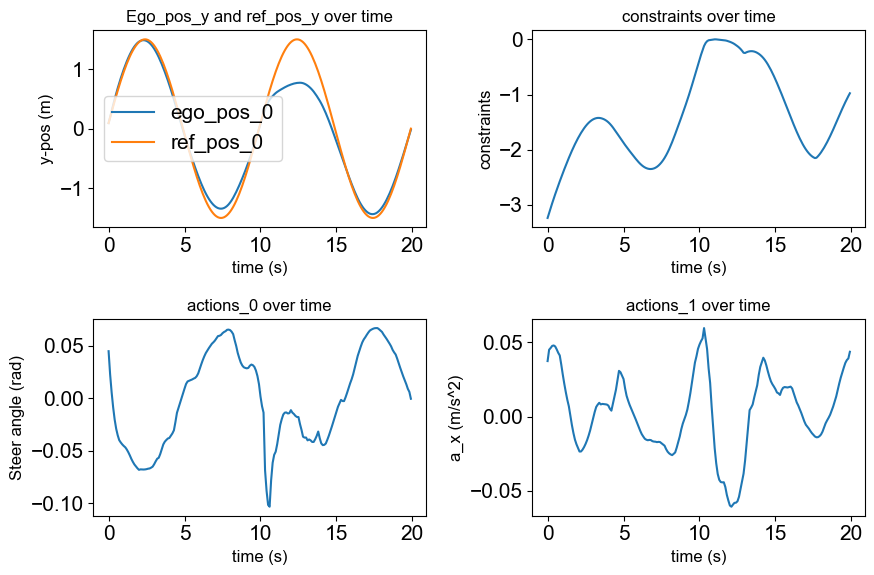

In [4]:
# plot curves
# draw a 2 * 2 figure, where the top left is the ref_pos_1 (red) and ego_pos_1 (blue) evolution
# over time; top right the constraints; bottom left the actions_0; bottom right the actions_1
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs[0, 0].plot(time_steps, ego_pos[:, 1], label="ego_pos_0")
axs[0, 0].plot(time_steps, ref_pos[:, 1], label="ref_pos_0")
axs[0, 0].set_title("Ego_pos_y and ref_pos_y over time", fontsize=12)
axs[0, 0].set_xlabel("time (s)", fontsize=12)
axs[0, 0].set_ylabel("y-pos (m)", fontsize=12)
axs[0, 0].legend()

axs[0, 1].plot(time_steps, constraints)
axs[0, 1].set_title("constraints over time", fontsize=12)
axs[0, 1].set_xlabel("time (s)", fontsize=12)
axs[0, 1].set_ylabel("constraints", fontsize=12)

axs[1, 0].plot(time_steps, actions[:, 0])
axs[1, 0].set_title("actions_0 over time", fontsize=12)
axs[1, 0].set_xlabel("time (s)", fontsize=12)
axs[1, 0].set_ylabel("Steer angle (rad)", fontsize=12)

axs[1, 1].plot(time_steps, actions[:, 1])
axs[1, 1].set_title("actions_1 over time", fontsize=12)
axs[1, 1].set_xlabel("time (s)", fontsize=12)
axs[1, 1].set_ylabel("a_x (m/s^2)", fontsize=12)

fig.tight_layout()

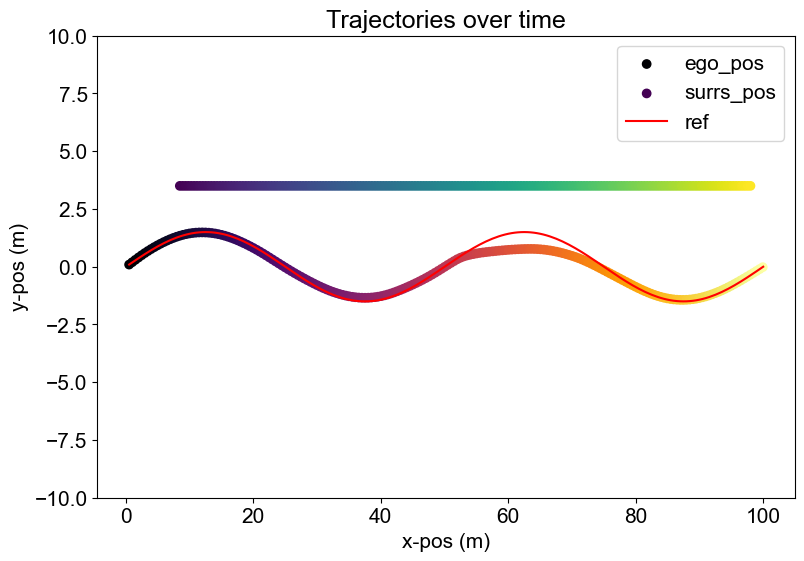

In [5]:
# draw a figure about the ego_pos, surrs_poses, ref_pos evoluation
# x-pos_0, y-pos_1 with scatter
# the color should be darker as time goes by

fig, axs = plt.subplots(1, 1, figsize=(9, 6))
axs.scatter(ego_pos[:, 0], ego_pos[:, 1], c=time_steps, label="ego_pos", cmap="inferno")
axs.scatter(surrs_poses[:, :, 0], surrs_poses[:, :, 1], c=time_steps, label="surrs_pos", cmap="viridis")
axs.plot(ref_pos[:, 0], ref_pos[:, 1], label="ref", c="red")
axs.set_title("Trajectories over time")
axs.set_xlabel("x-pos (m)")
axs.set_ylabel("y-pos (m)")
axs.set_ylim(-10, 10)
axs.legend()

In [6]:
# draw animations
fig = plt.figure()
im = plt.imshow(video[0,:,:,:])
plt.axis('off')

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

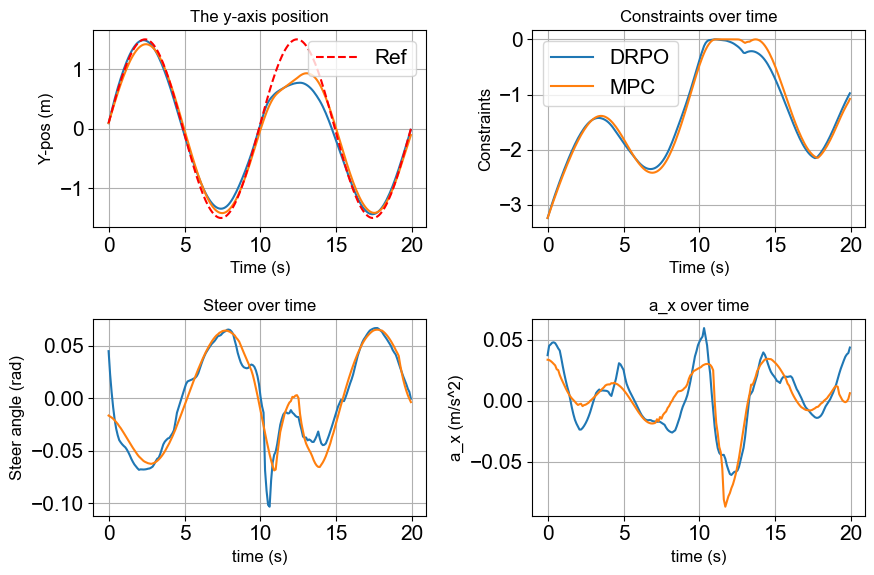

In [19]:
# load MPC data to a dataframe and plot comparison
mpc_data = pd.read_csv(run_dir / "MPC" / 'mpc_data.csv')

fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs[0, 0].plot(time_steps, ego_pos[:, 1])
axs[0, 0].plot(time_steps, mpc_data["ego_pos_1"])
axs[0, 0].plot(time_steps, ref_pos[:, 1], label="Ref", c="red", linestyle="--")
axs[0, 0].set_title("The y-axis position", fontsize=12)
axs[0, 0].set_xlabel("Time (s)", fontsize=12)
axs[0, 0].set_ylabel("Y-pos (m)", fontsize=12)
axs[0, 0].legend()

axs[0, 1].plot(time_steps, constraints, label="DRPO")
axs[0, 1].plot(time_steps, mpc_data["constraints"], label="MPC")
axs[0, 1].set_title("Constraints over time", fontsize=12)
axs[0, 1].set_xlabel("Time (s)", fontsize=12)
axs[0, 1].set_ylabel("Constraints", fontsize=12)
axs[0, 1].legend()

axs[1, 0].plot(time_steps, actions[:, 0], label="DRPO")
axs[1, 0].plot(time_steps, mpc_data["actions_0"], label="MPC")
axs[1, 0].set_title("Steer over time", fontsize=12)
axs[1, 0].set_xlabel("time (s)", fontsize=12)
axs[1, 0].set_ylabel("Steer angle (rad)", fontsize=12)

axs[1, 1].plot(time_steps, actions[:, 1], label="DRPO")
axs[1, 1].plot(time_steps, mpc_data["actions_1"], label="MPC")
axs[1, 1].set_title("a_x over time", fontsize=12)
axs[1, 1].set_xlabel("time (s)", fontsize=12)
axs[1, 1].set_ylabel("a_x (m/s^2)", fontsize=12)

for ax in axs.flat:
    ax.grid(True)
fig.tight_layout()

In [8]:
# compute the steer and a_x max and mean error and print
steer_error = np.abs(actions[:, 0] - mpc_data["actions_0"])
steer_range = np.max(mpc_data["actions_0"]) - np.min(mpc_data["actions_0"])
ax_error = np.abs(actions[:, 1] - mpc_data["actions_1"])
ax_range = np.max(mpc_data["actions_1"]) - np.min(mpc_data["actions_1"])

print(f"steer max error: {np.max(steer_error) / (np.pi / 3)}, mean error: {np.mean(steer_error) / (np.pi / 3)}")
print(f"a_x max error: {np.max(ax_error) / 6}, mean error: {np.mean(ax_error) / 6}")

steer max error: 0.05856793154923359, mean error: 0.008687246245871656
a_x max error: 0.0065544508827203125, mean error: 0.001778512462963232


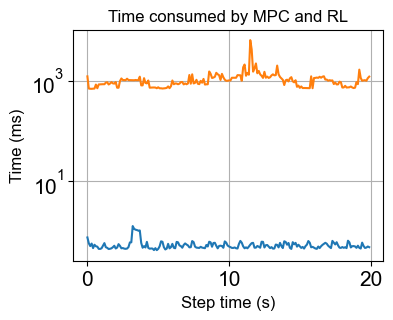

In [17]:
# plot the time consumed by MPC and RL with log-y
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
axs.plot(time_steps, np.array(info_traj[0]["time"]) * 1000, label="DRPO")
axs.plot(time_steps, mpc_data["time"] * 1000, label="MPC")
axs.set_title("Time consumed by MPC and RL", fontsize=12)
axs.set_xlabel("Step time (s)", fontsize=12)
axs.set_ylabel("Time (ms)", fontsize=12)
axs.set_yscale("log")

# turn on the grid
axs.grid(True)